<a href="https://colab.research.google.com/github/marcinwolter/MachineLearnin2019/blob/master/bnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
import  imageio

In [0]:
%matplotlib inline

In [0]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

In [0]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

In [0]:
net = NN(28*28, 1024, 10)

In [36]:
!pip install pyro-ppl

import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [0]:
log_softmax = nn.LogSoftmax(dim=1)

In [0]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [0]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [0]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [41]:
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:368: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Epoch  0  Loss  95.00458729117712
Epoch  1  Loss  88.52888103162448
Epoch  2  Loss  86.85993972291946
Epoch  3  Loss  86.42658432003657
Epoch  4  Loss  86.30982657821973


In [42]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
    correct += (predicted == np.array(labels)).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict


/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:368: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


accuracy: 90 %


In [0]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [0]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)
    #mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean, axis=1)

In [0]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        if (predicted_for_images>0):
           print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        else:
           print("Accuracy when predicted: ",correct_predictions," / ",predicted_for_images)   
        
    return len(labels), correct_predictions, predicted_for_images 
    

In [47]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))


Prediction when network can refuse


/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:368: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Total images:  10000
Skipped:  993
Accuracy when made predictions: 95 %


In [0]:
# preparing for evaluation

dataiter = iter(test_loader)
images, labels = dataiter.next()

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:368: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Real:  9


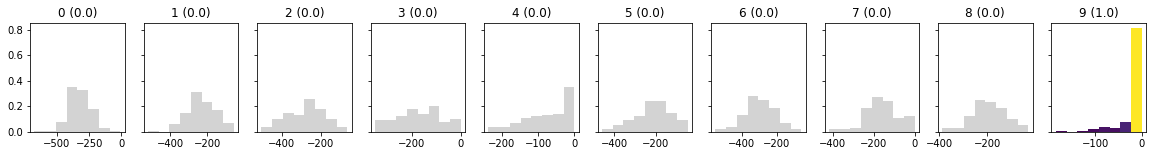

Correct


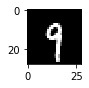

Real:  3


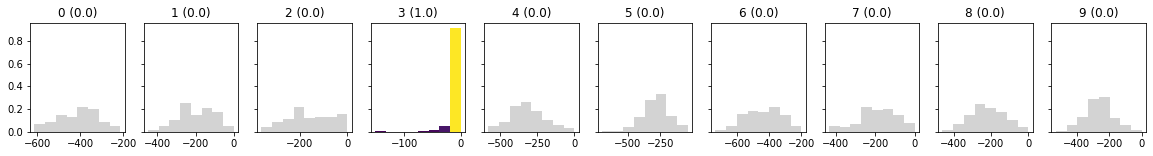

Correct


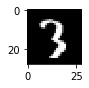

Real:  4


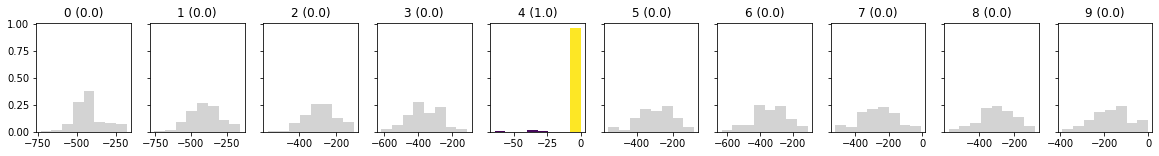

Correct


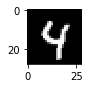

Real:  6


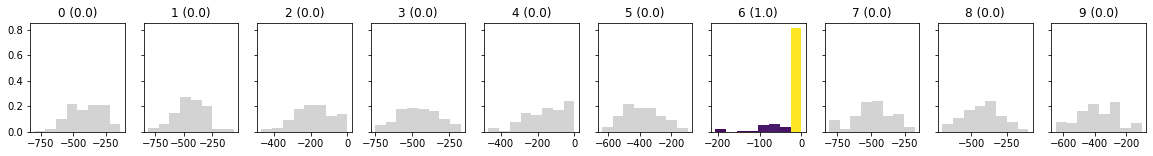

Correct


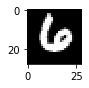

Real:  7


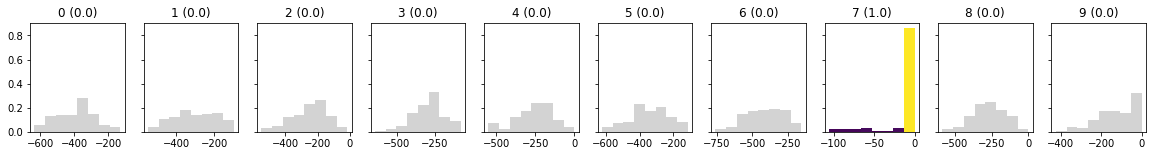

Correct


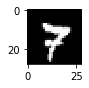

Real:  0


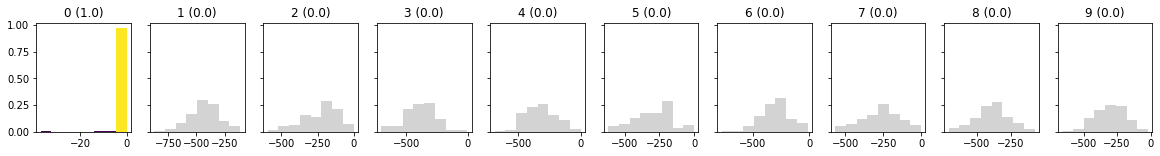

Correct


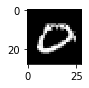

Real:  1


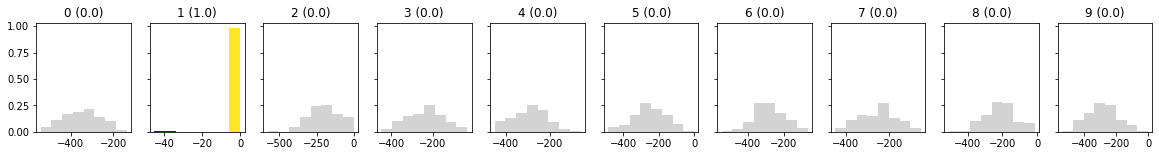

Correct


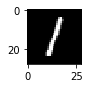

Real:  0


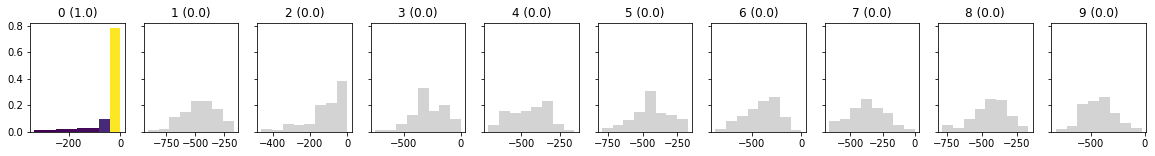

Correct


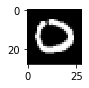

Real:  1


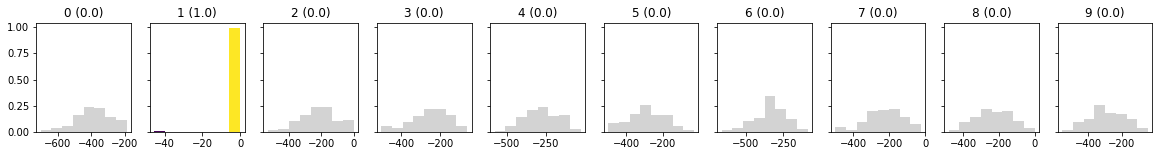

Correct


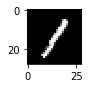

Real:  6


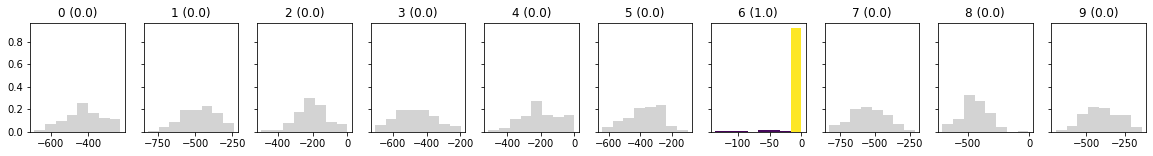

Correct


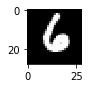

Real:  1


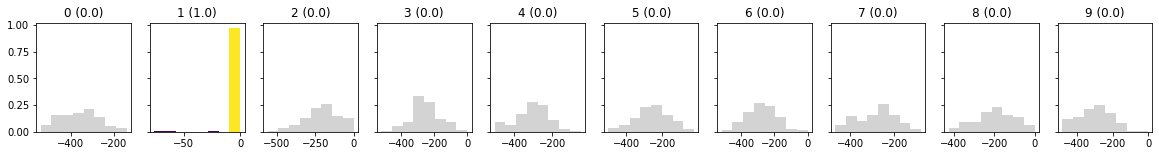

Correct


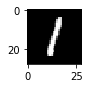

Real:  6


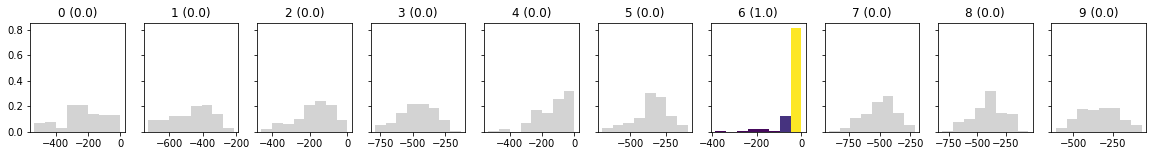

Correct


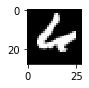

Real:  2


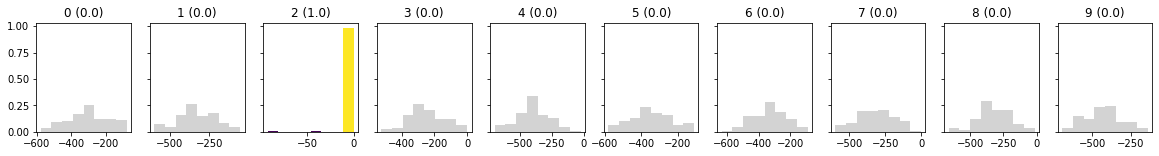

Correct


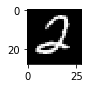

Real:  2


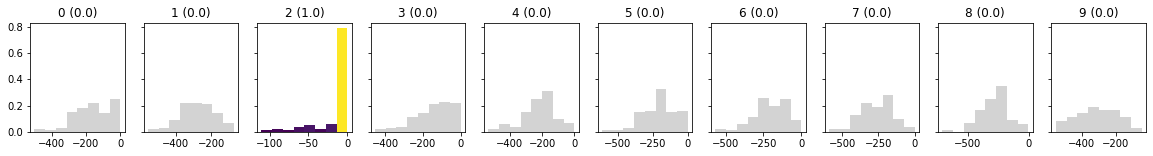

Correct


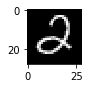

Real:  8


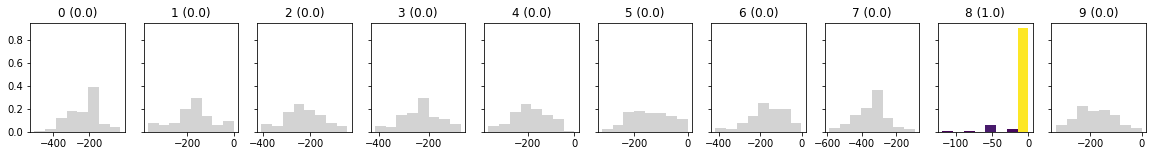

Correct


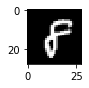

Real:  4


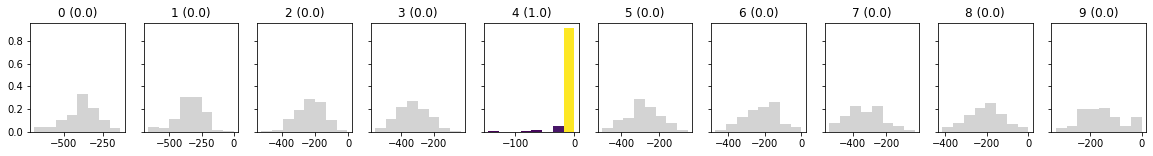

Correct


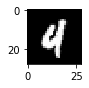

Real:  0


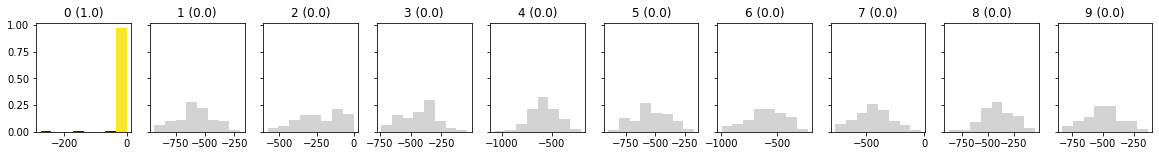

Correct


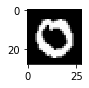

Real:  3


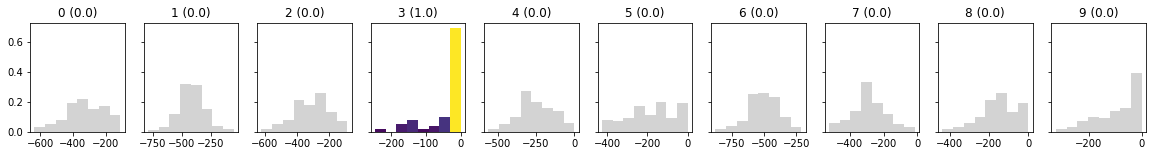

Correct


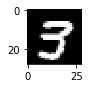

Real:  1


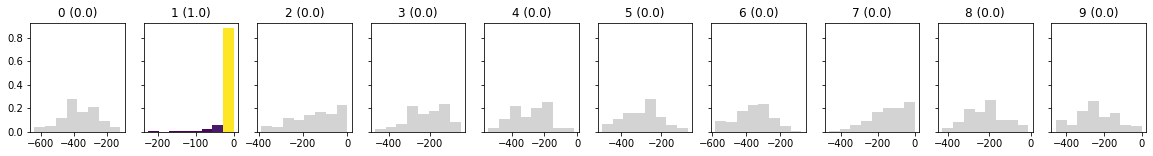

Correct


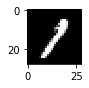

Real:  2


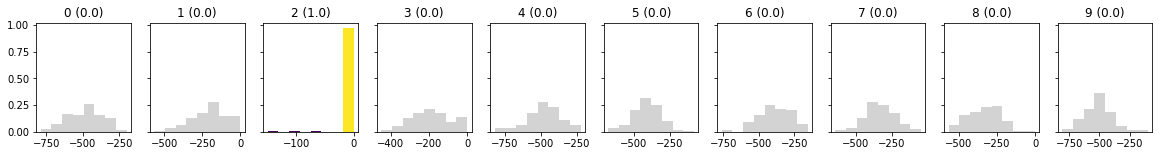

Correct


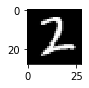

Real:  4


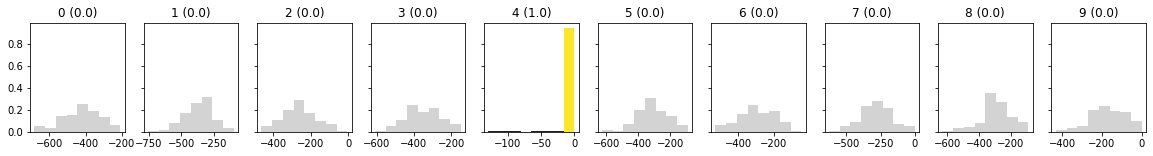

Correct


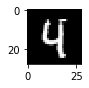

Real:  2


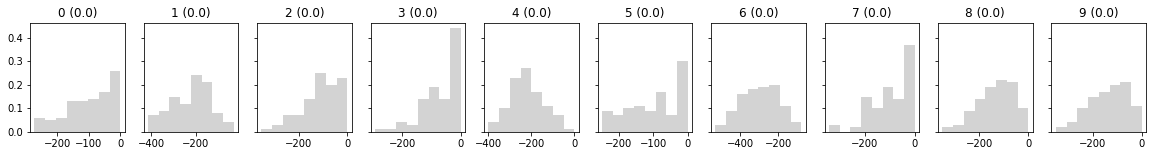

Undecided.


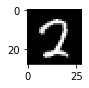

Real:  0


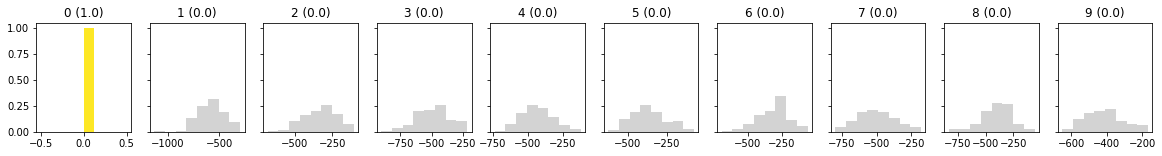

Correct


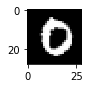

Real:  0


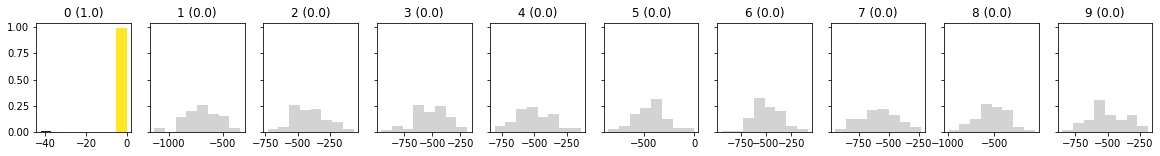

Correct


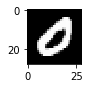

Real:  6


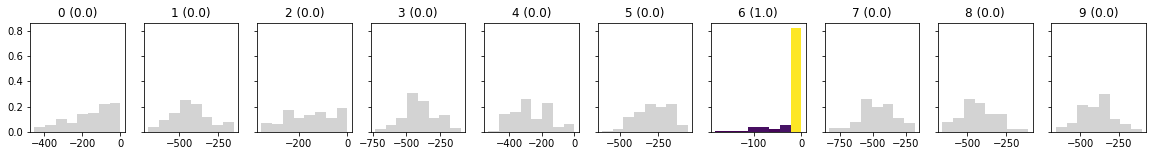

Correct


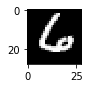

Real:  5


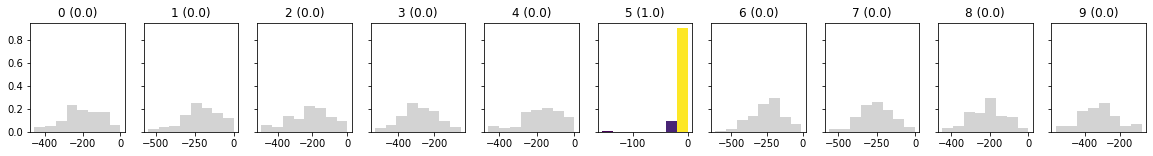

Correct


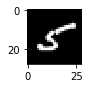

Real:  1


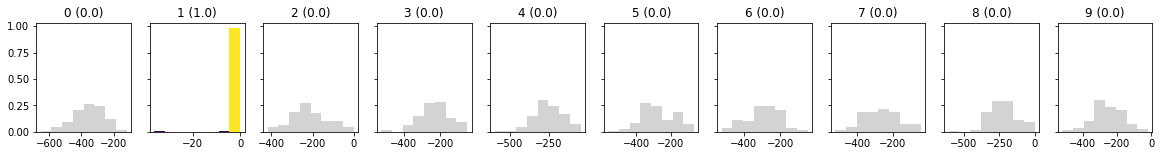

Correct


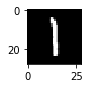

Real:  6


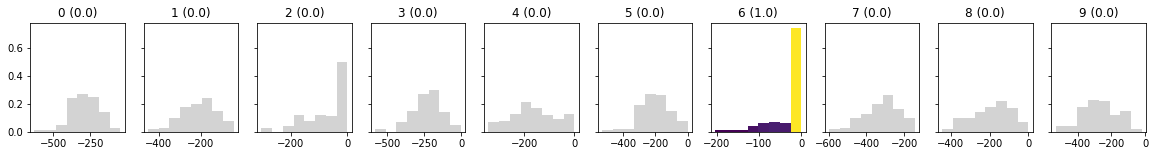

Correct


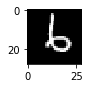

Real:  2


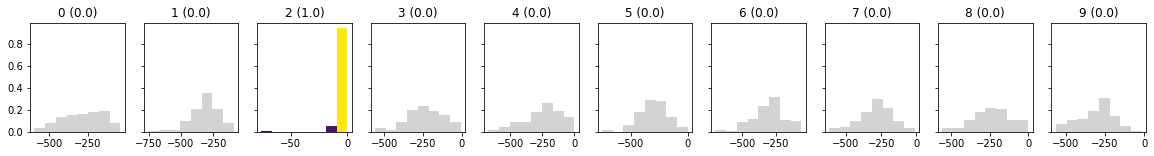

Correct


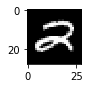

Real:  5


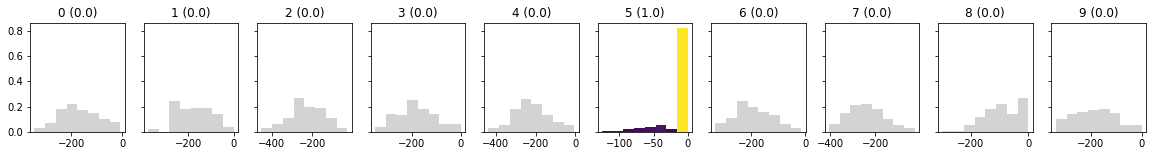

Correct


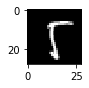

Real:  2


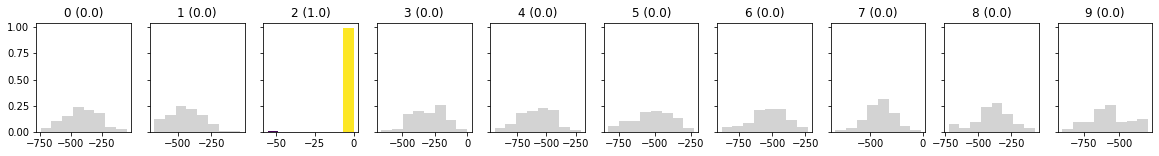

Correct


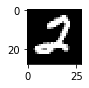

Real:  3


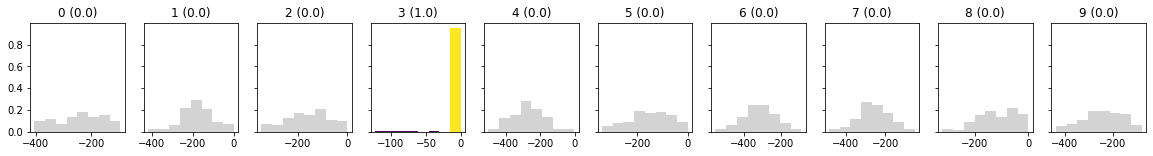

Correct


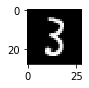

Real:  9


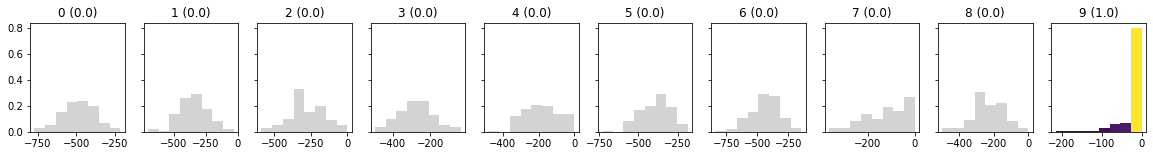

Correct


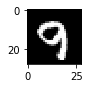

Real:  1


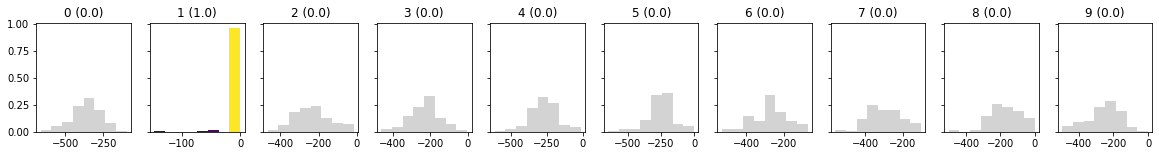

Correct


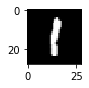

Real:  5


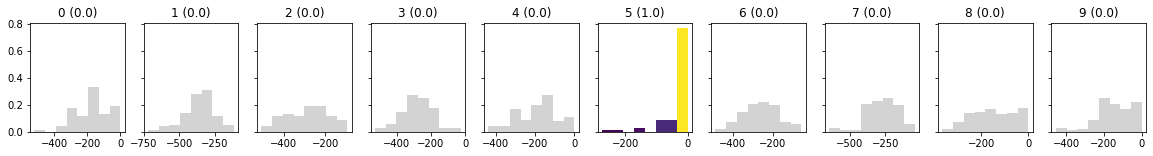

Correct


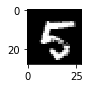

Real:  5


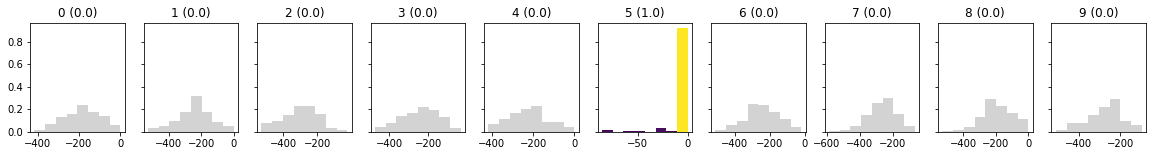

Correct


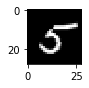

Real:  2


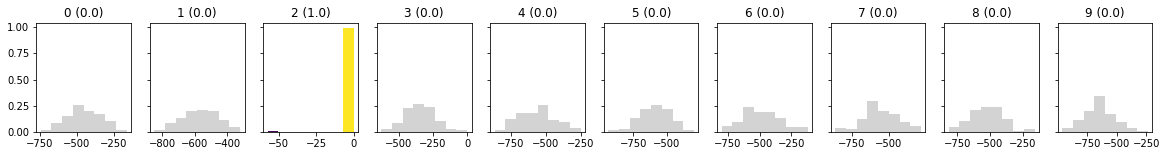

Correct


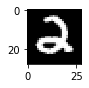

Real:  0


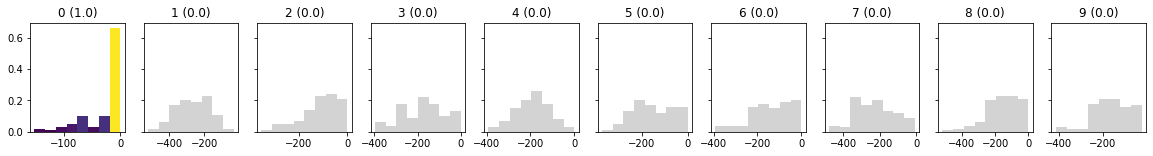

Correct


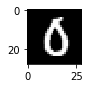

Real:  2


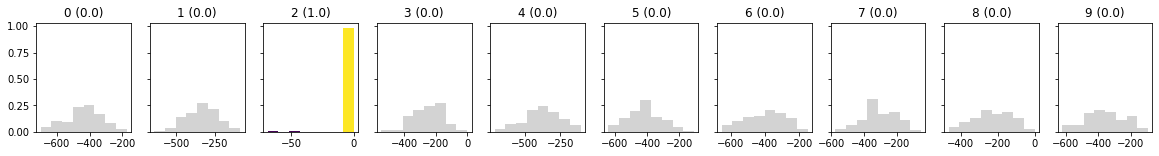

Correct


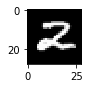

Real:  0


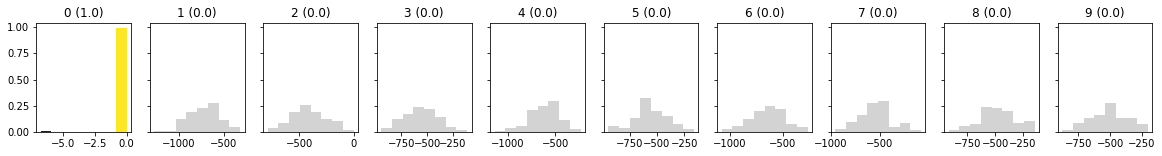

Correct


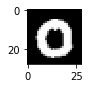

Real:  8


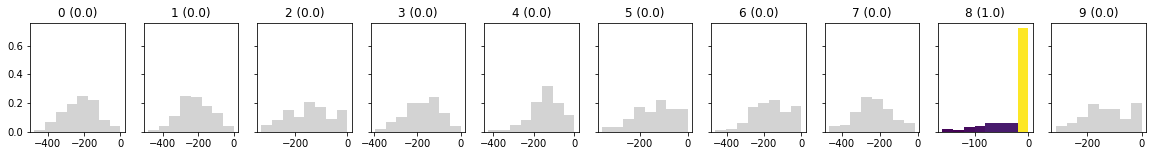

Correct


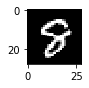

Real:  6


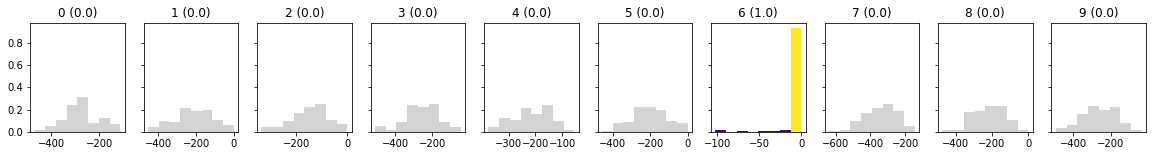

Correct


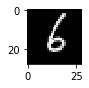

Real:  9


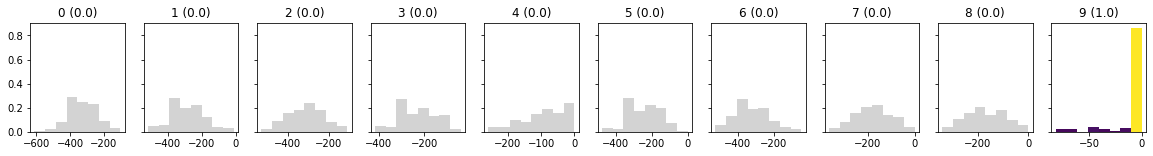

Correct


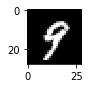

Real:  6


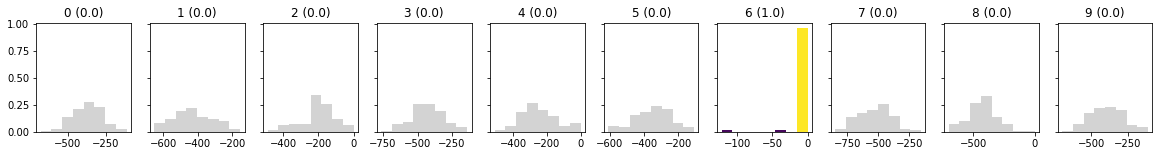

Correct


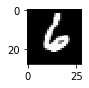

Real:  8


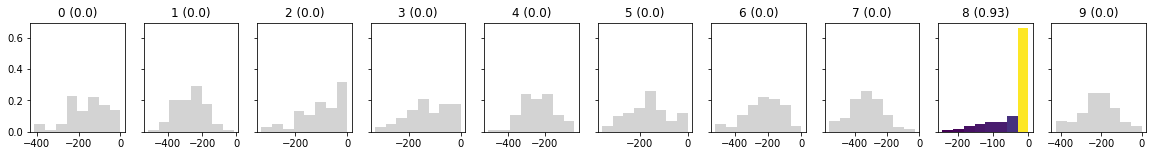

Correct


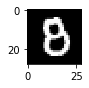

Real:  4


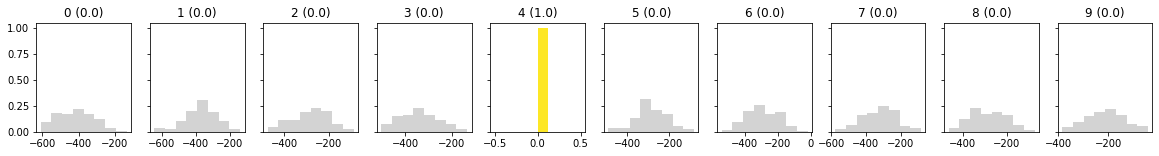

Correct


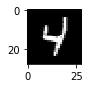

Real:  4


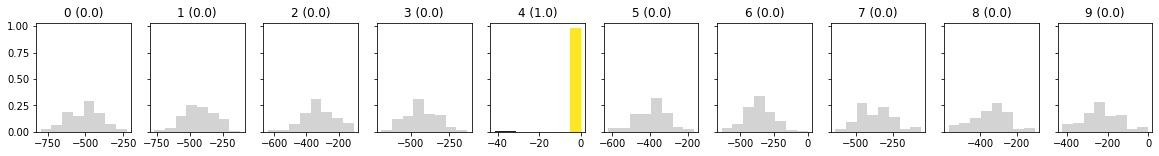

Correct


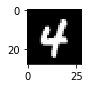

Real:  4


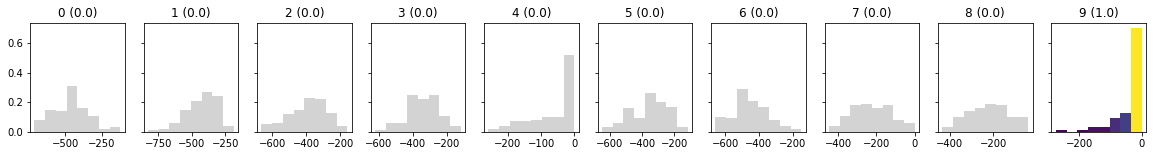

Incorrect :()


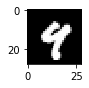

Real:  6


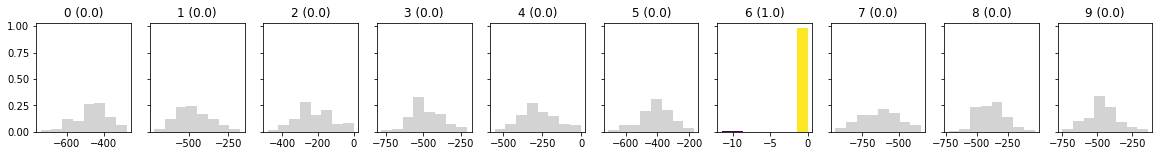

Correct


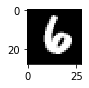

Real:  2


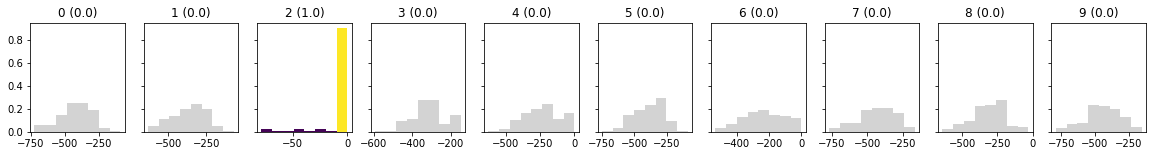

Correct


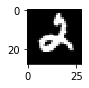

Real:  2


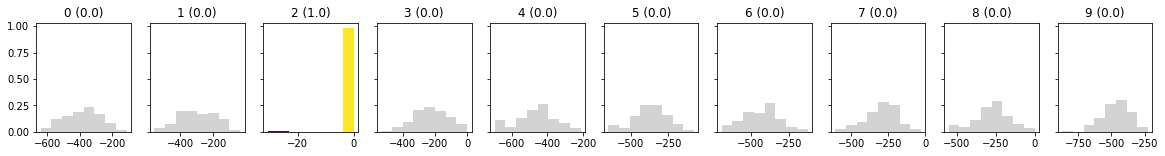

Correct


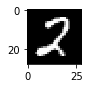

Real:  7


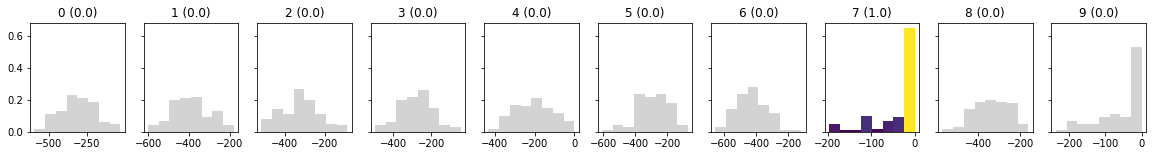

Correct


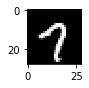

Real:  4


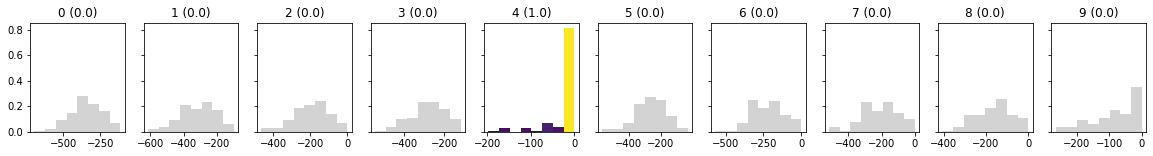

Correct


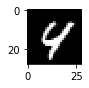

Real:  6


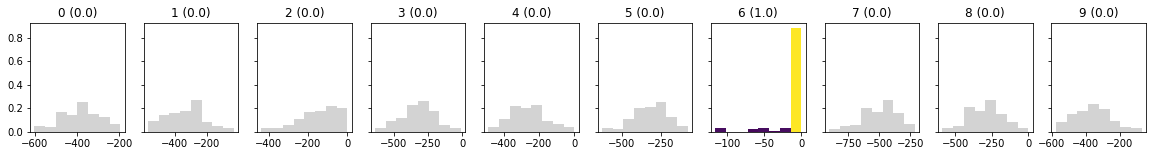

Correct


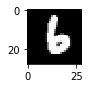

Real:  9


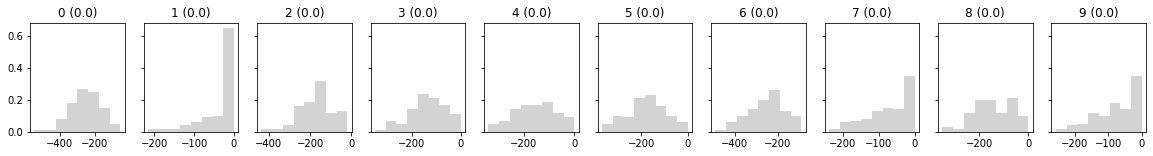

Undecided.


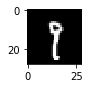

Real:  7


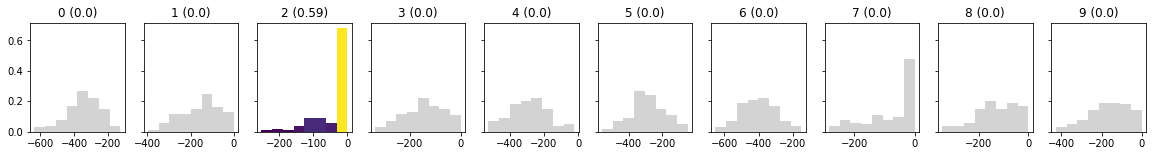

Incorrect :()


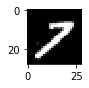

Real:  7


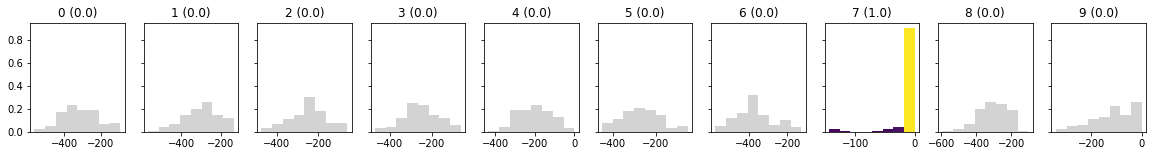

Correct


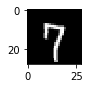

Real:  8


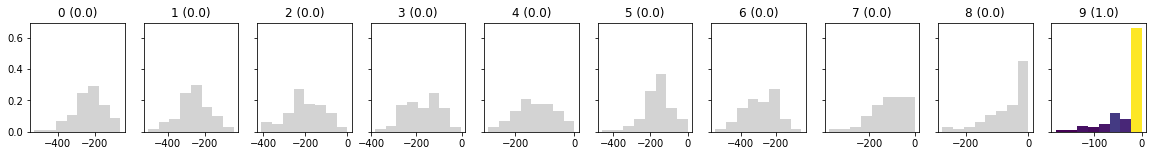

Incorrect :()


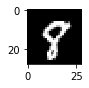

Real:  1


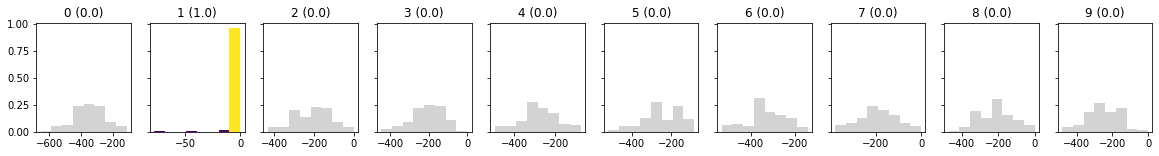

Correct


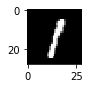

Real:  5


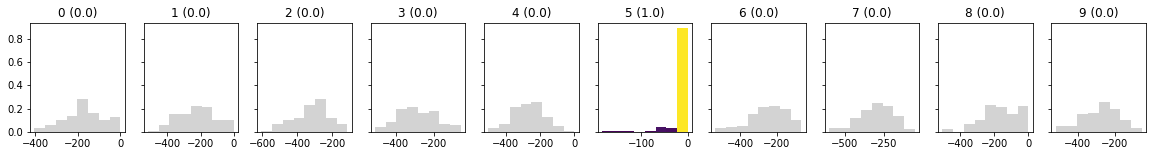

Correct


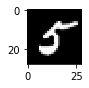

Real:  7


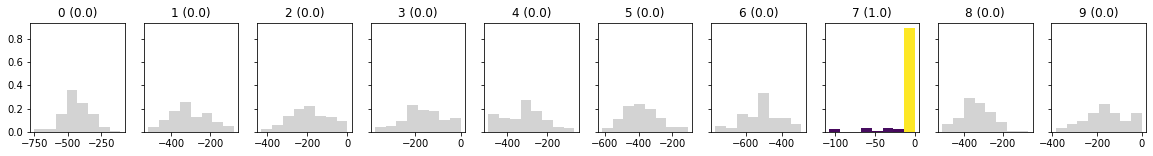

Correct


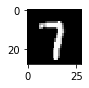

Real:  1


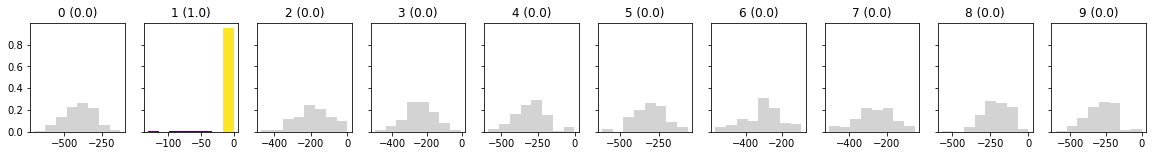

Correct


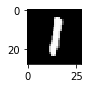

Real:  1


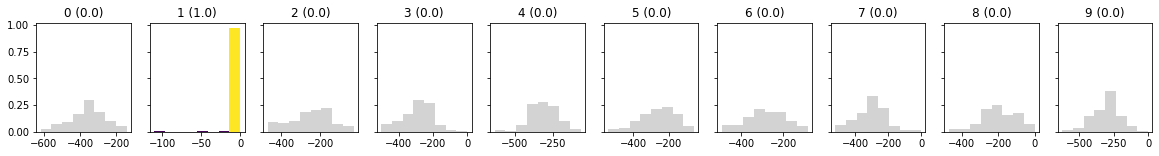

Correct


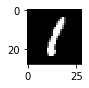

Real:  9


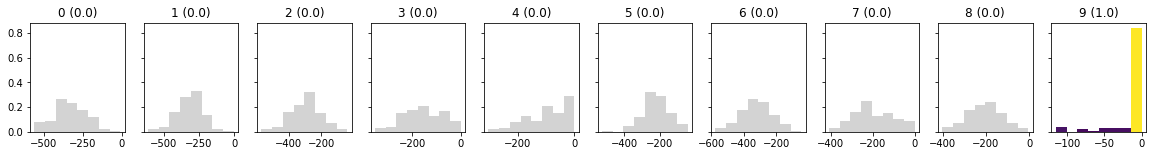

Correct


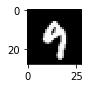

Real:  3


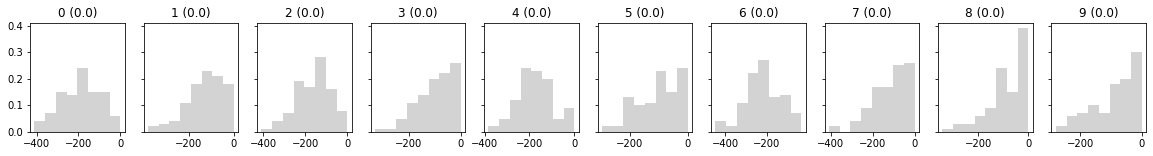

Undecided.


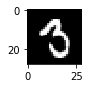

Real:  3


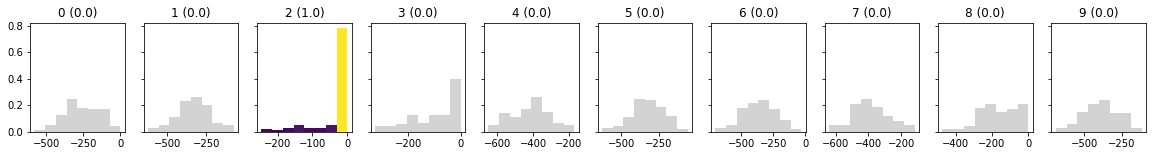

Incorrect :()


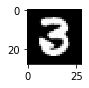

Real:  4


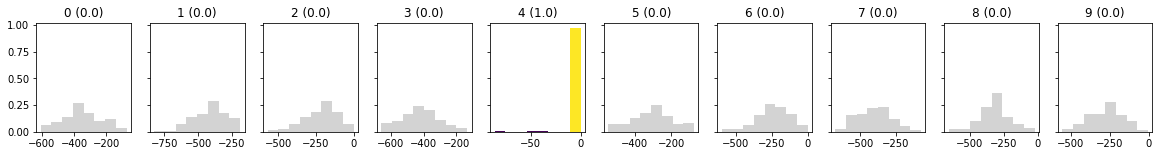

Correct


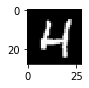

Real:  4


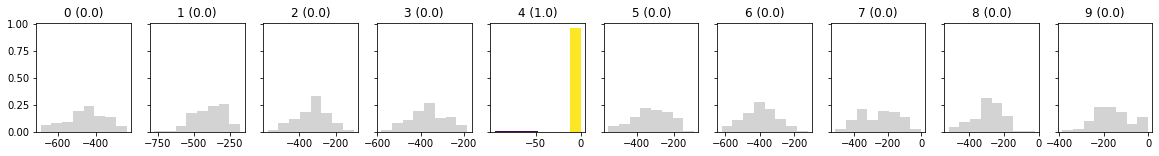

Correct


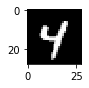

Real:  0


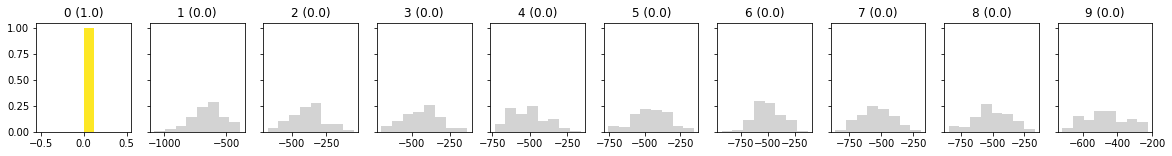

Correct


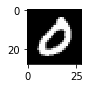

Real:  1


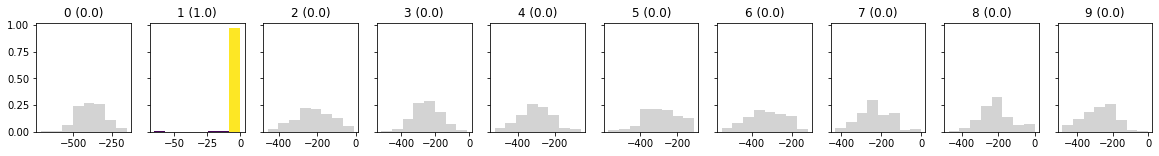

Correct


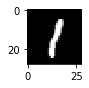

Real:  0


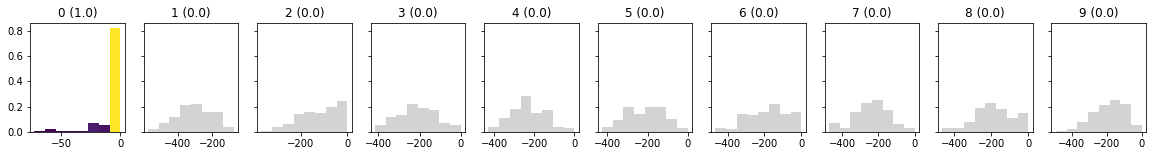

Correct


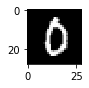

Real:  9


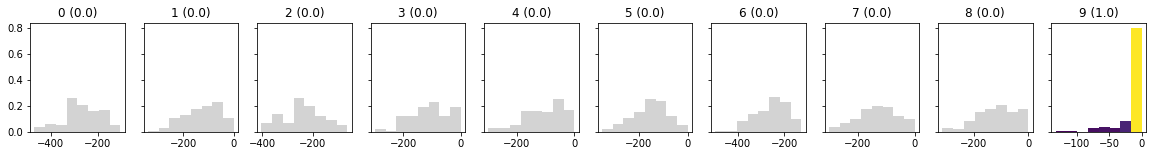

Correct


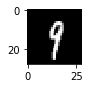

Real:  1


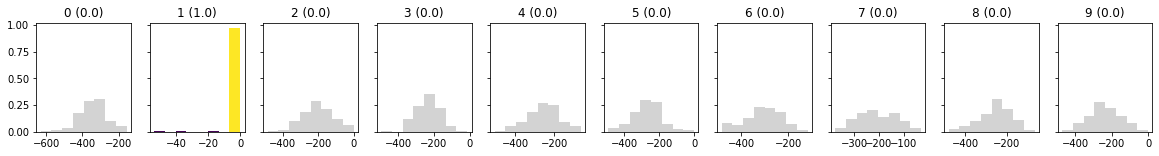

Correct


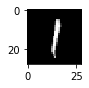

Real:  4


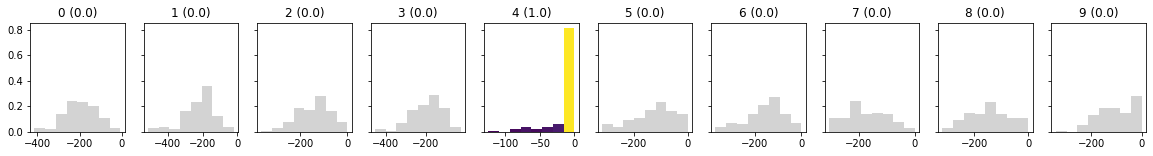

Correct


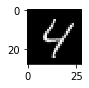

Real:  1


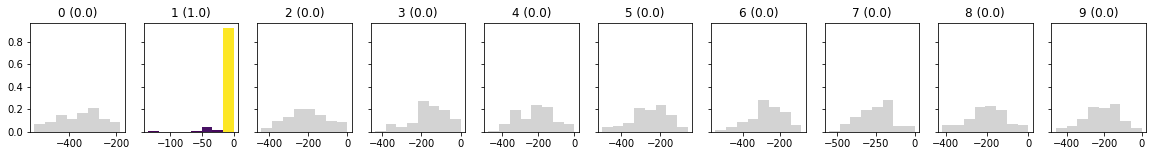

Correct


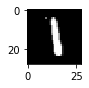

Real:  8


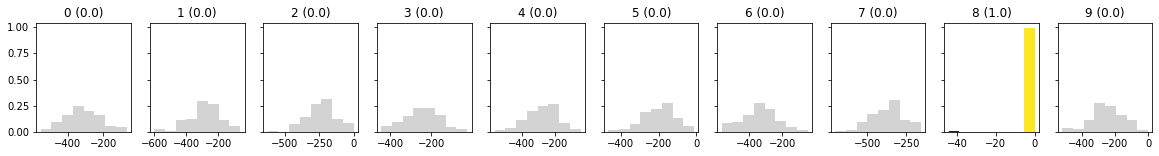

Correct


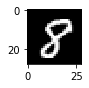

Real:  8


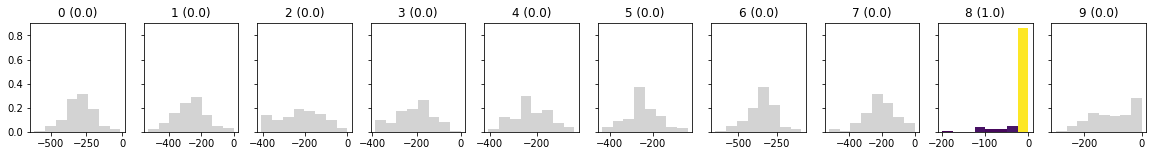

Correct


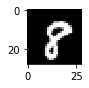

Real:  1


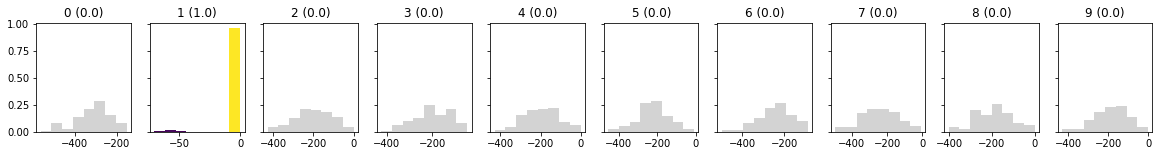

Correct


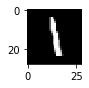

Real:  4


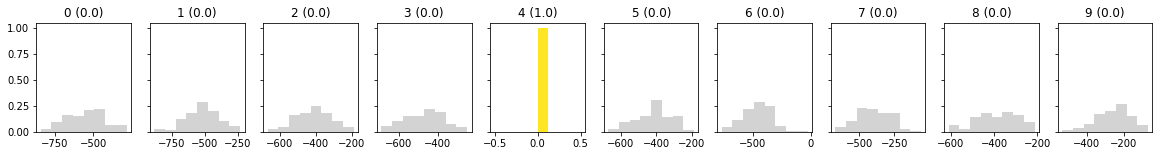

Correct


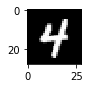

Real:  5


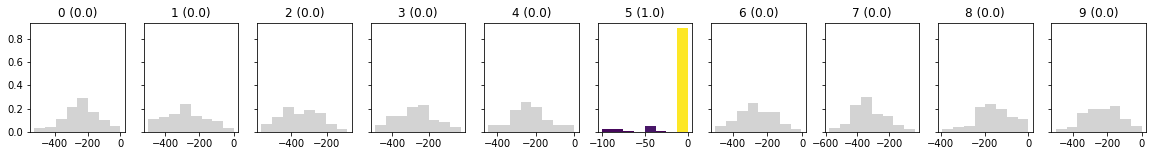

Correct


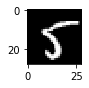

Real:  1


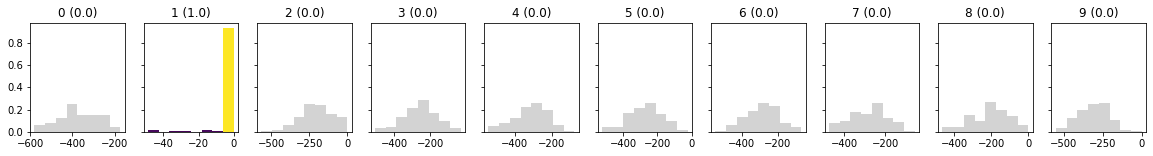

Correct


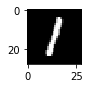

Real:  2


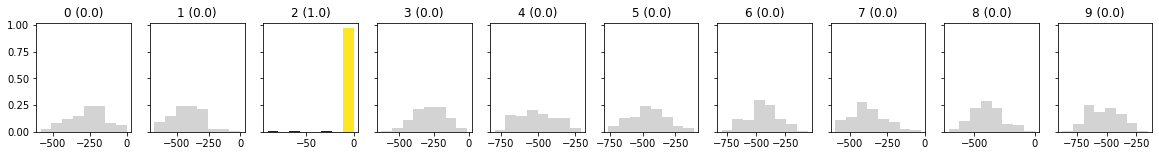

Correct


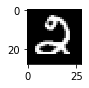

Real:  1


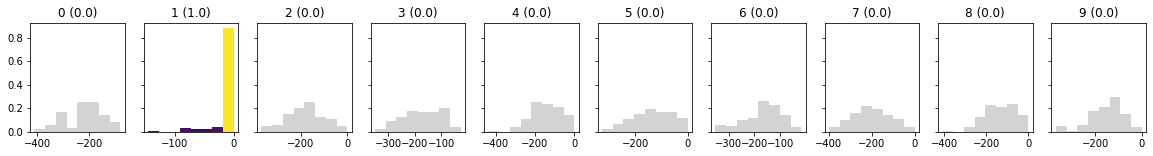

Correct


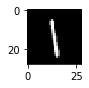

Real:  3


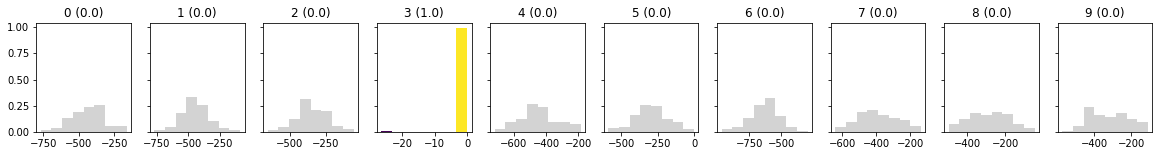

Correct


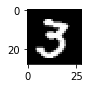

Real:  0


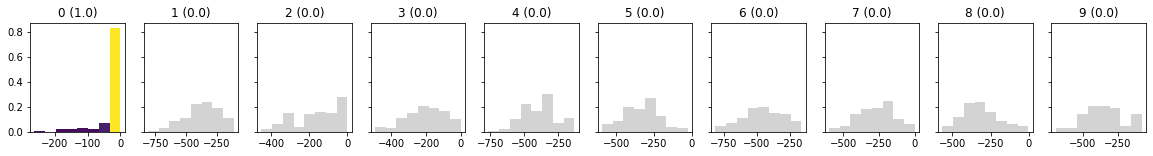

Correct


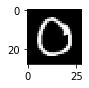

Real:  7


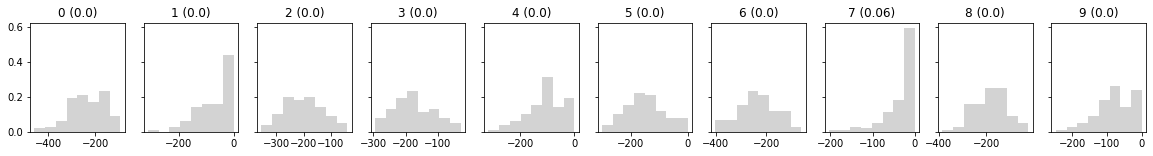

Undecided.


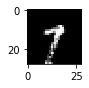

Real:  9


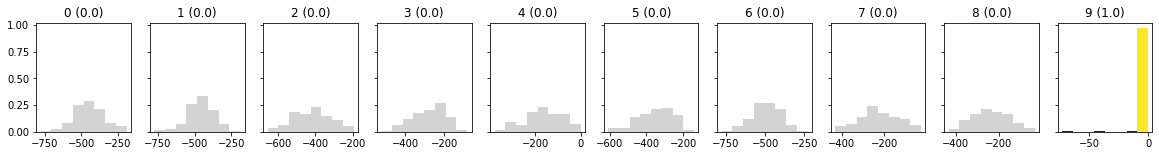

Correct


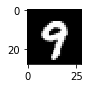

Real:  6


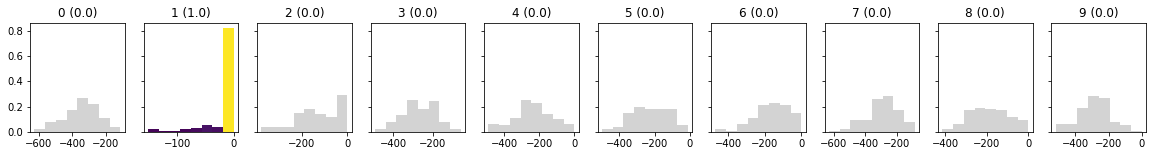

Incorrect :()


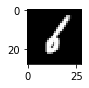

Real:  0


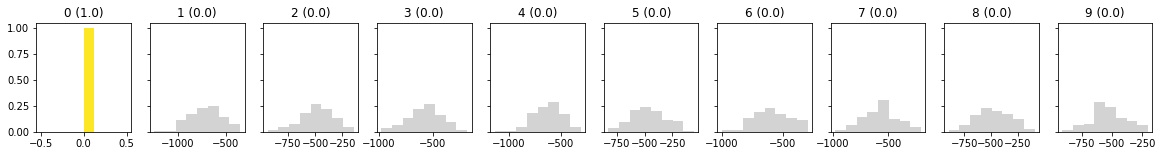

Correct


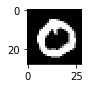

Real:  6


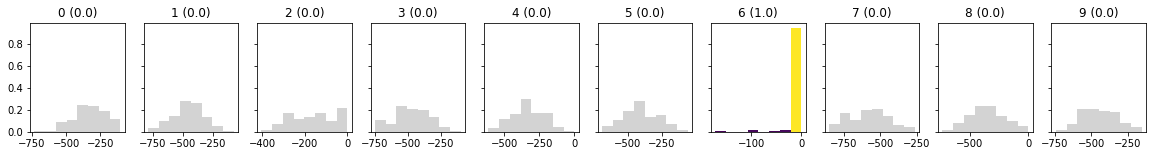

Correct


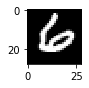

Real:  7


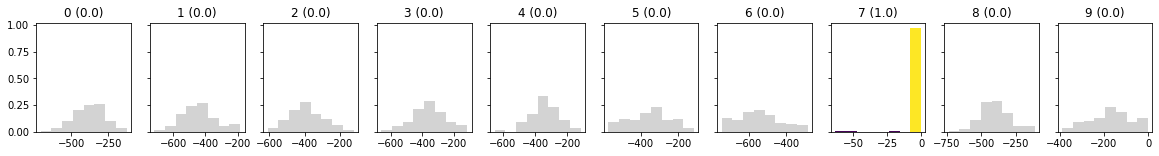

Correct


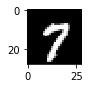

Real:  3


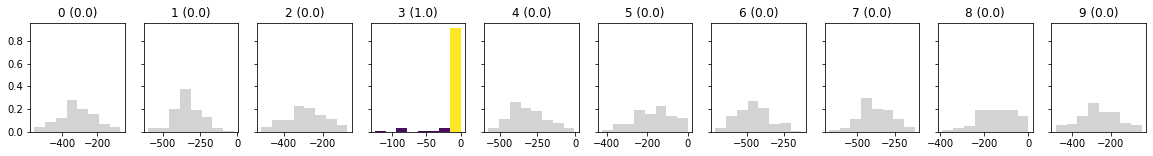

Correct


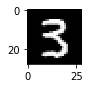

Real:  6


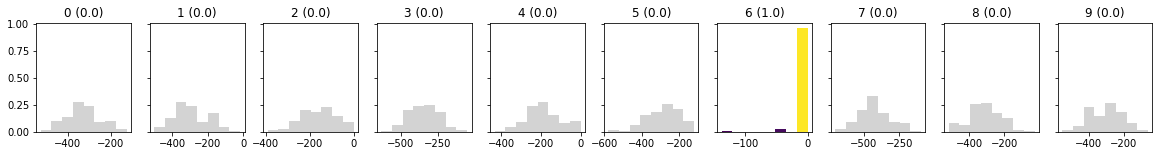

Correct


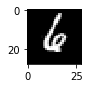

Real:  5


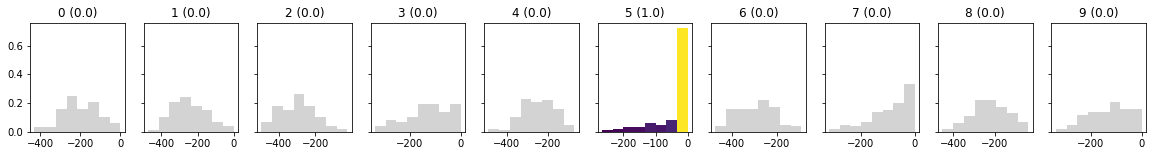

Correct


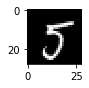

Real:  7


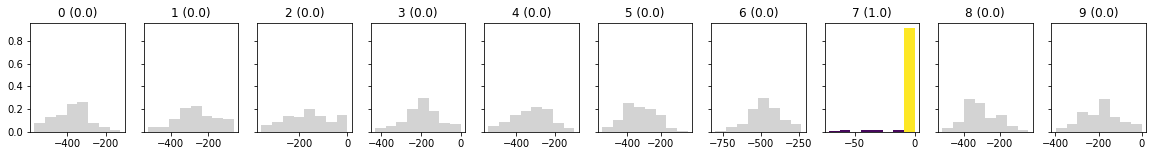

Correct


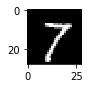

Real:  7


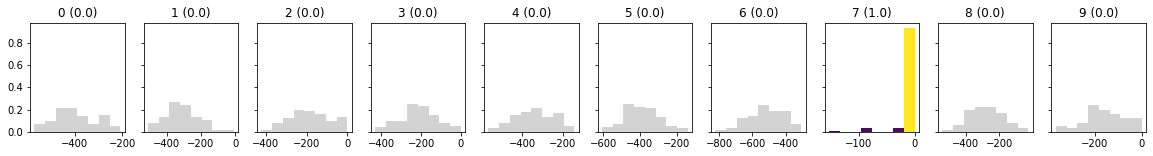

Correct


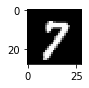

Real:  2


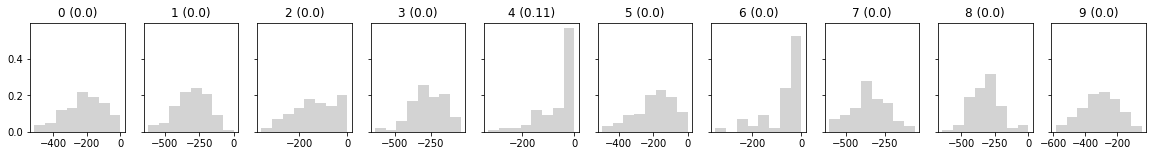

Undecided.


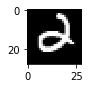

Real:  4


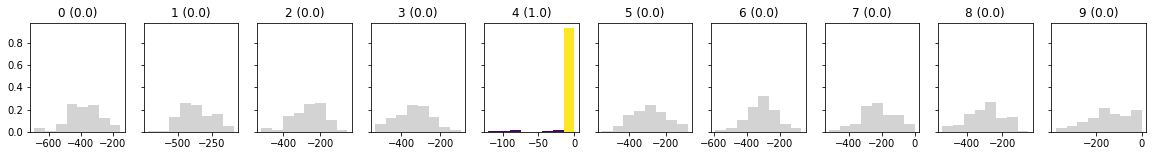

Correct


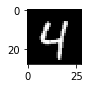

Real:  7


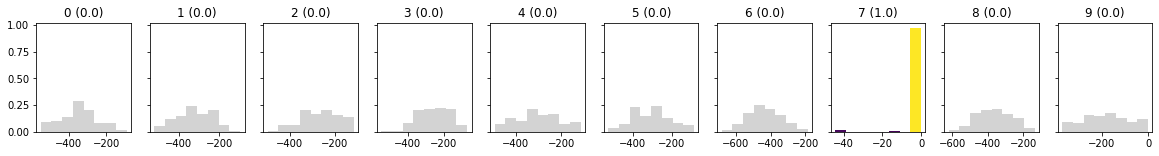

Correct


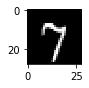

Real:  0


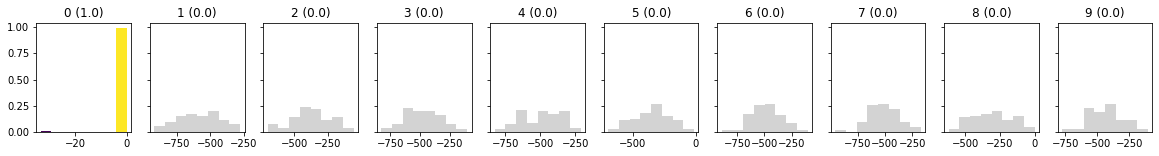

Correct


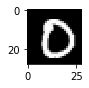

Summary
Total images:  100
Predicted for:  95
Accuracy when predicted:  0.9473684210526315


(100, 90.0, 95)

In [49]:
test_batch(images[:100], labels[:100])

In [0]:
# generate random data

images_random = torch.rand(100,28,28)
labels_random = torch.randint(0,10, (100,))

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:368: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Real:  4


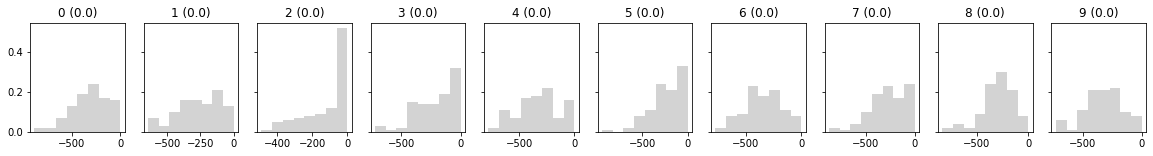

Undecided.


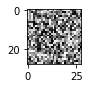

Real:  2


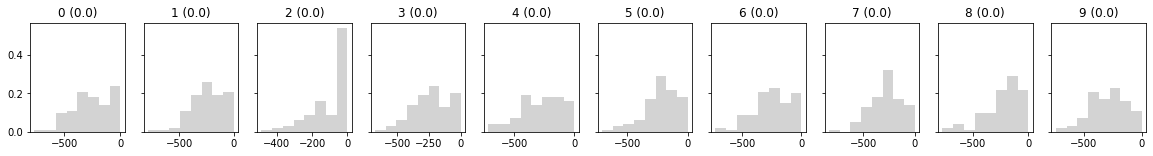

Undecided.


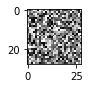

Real:  6


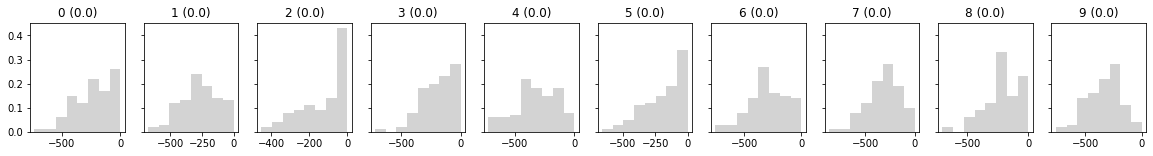

Undecided.


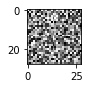

Real:  5


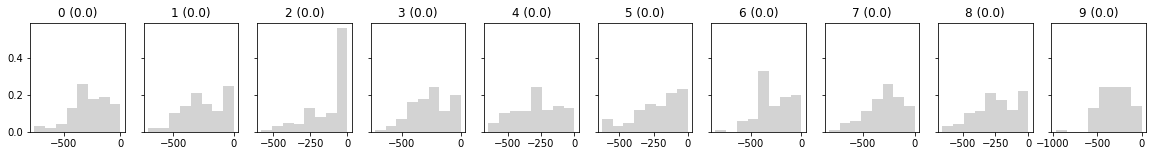

Undecided.


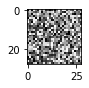

Real:  7


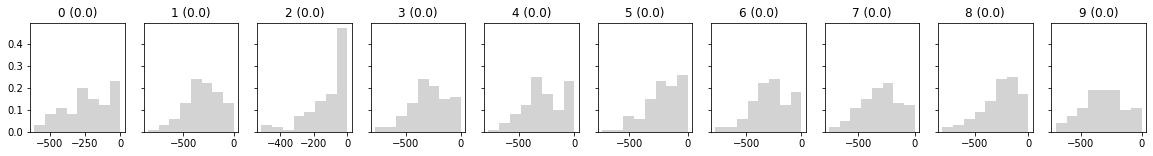

Undecided.


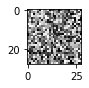

Real:  3


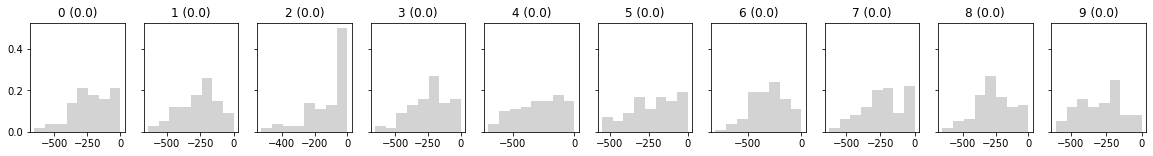

Undecided.


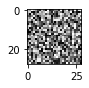

Real:  5


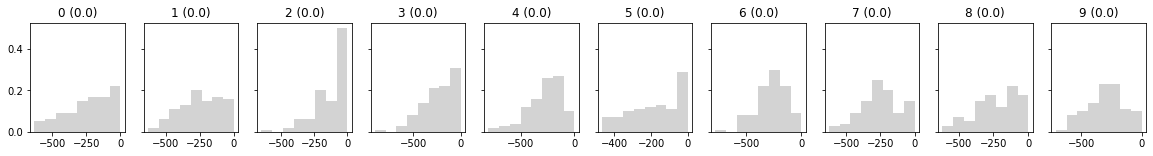

Undecided.


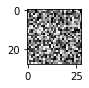

Real:  2


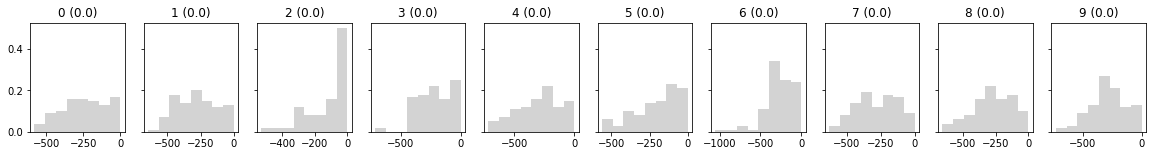

Undecided.


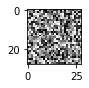

Real:  6


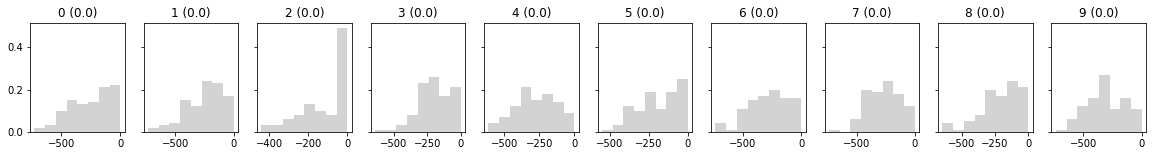

Undecided.


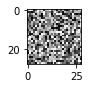

Real:  4


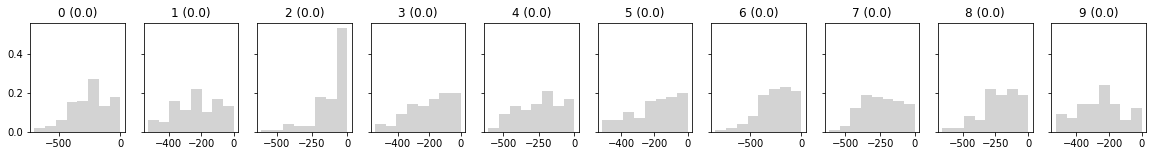

Undecided.


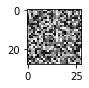

Real:  5


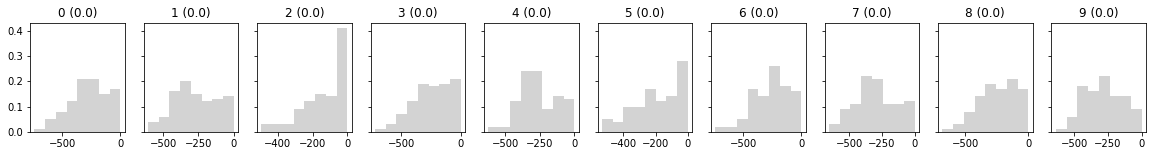

Undecided.


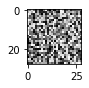

Real:  1


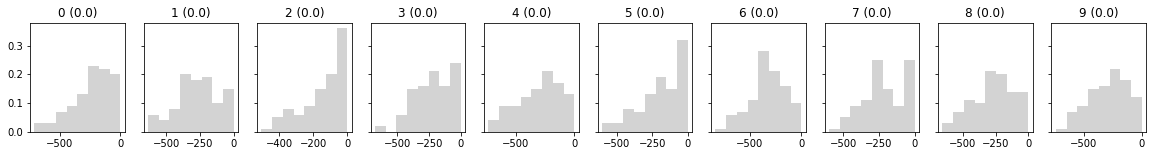

Undecided.


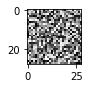

Real:  9


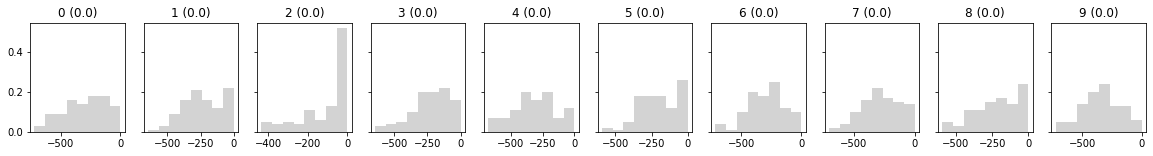

Undecided.


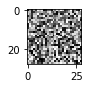

Real:  0


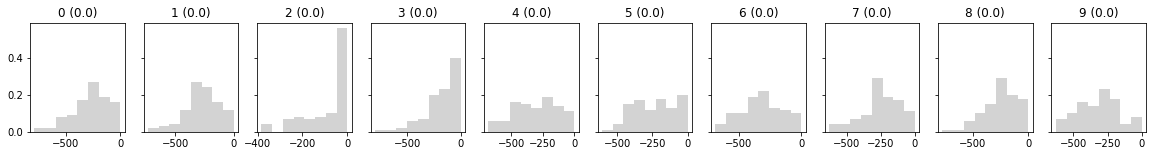

Undecided.


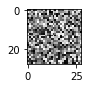

Real:  5


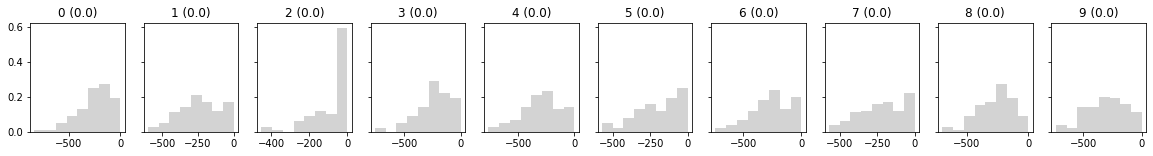

Undecided.


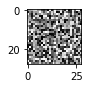

Real:  4


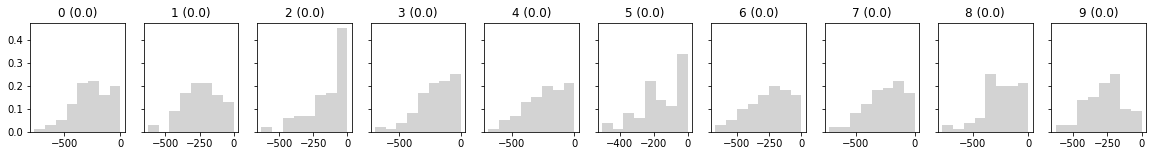

Undecided.


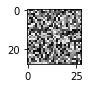

Real:  8


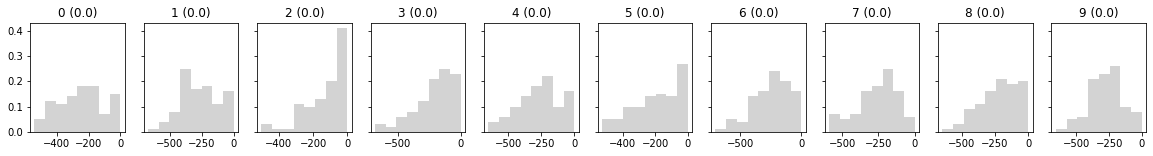

Undecided.


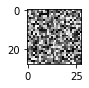

Real:  9


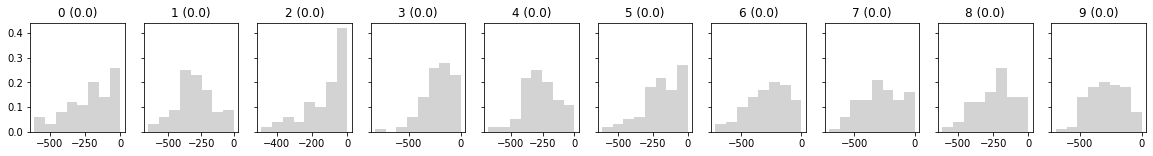

Undecided.


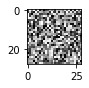

Real:  4


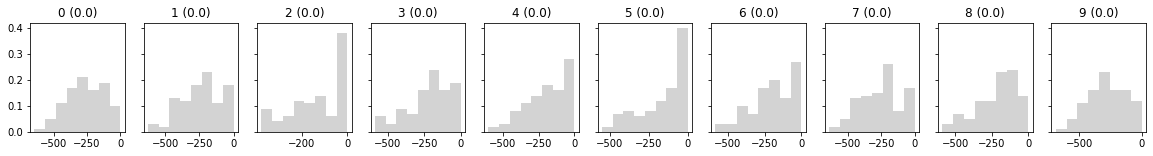

Undecided.


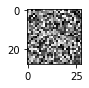

Real:  7


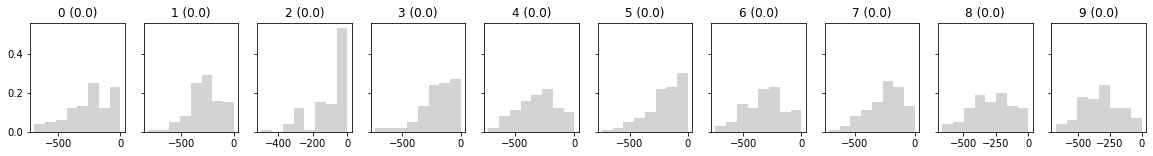

Undecided.


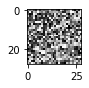

Real:  2


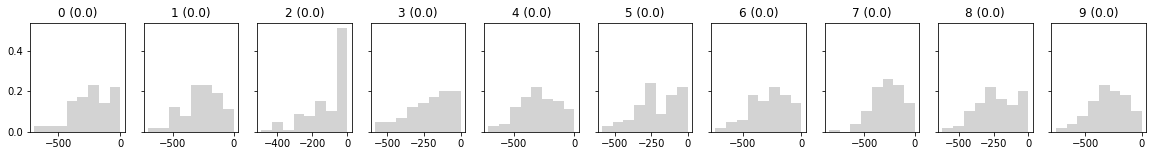

Undecided.


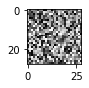

Real:  3


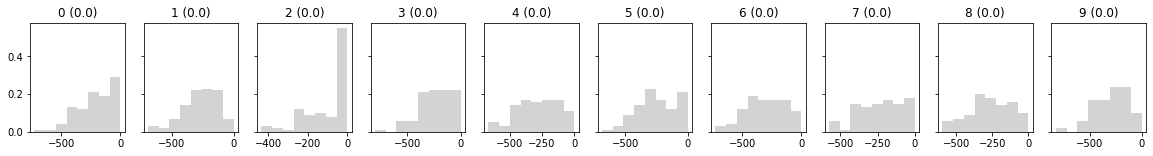

Undecided.


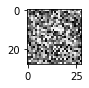

Real:  4


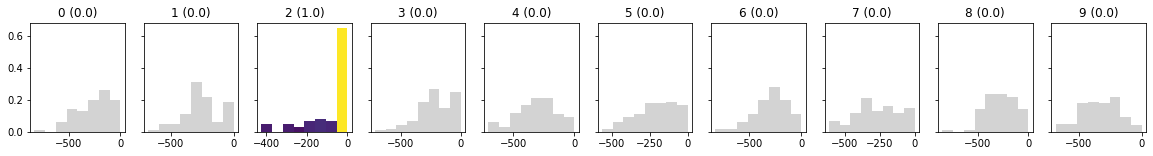

Incorrect :()


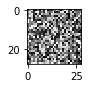

Real:  0


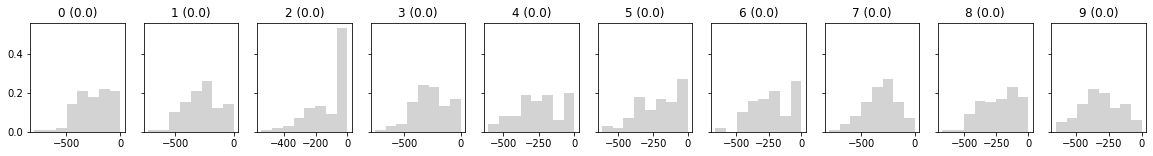

Undecided.


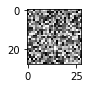

Real:  3


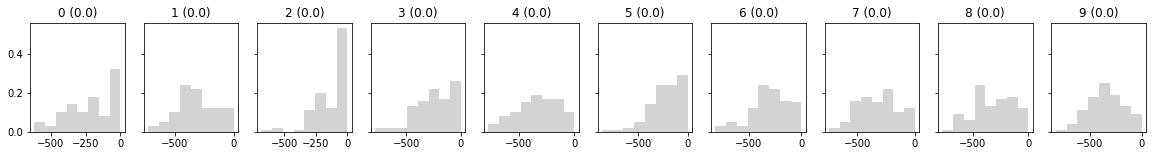

Undecided.


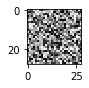

Real:  8


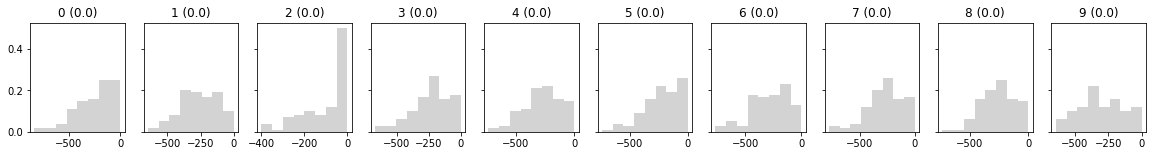

Undecided.


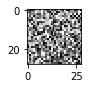

Real:  1


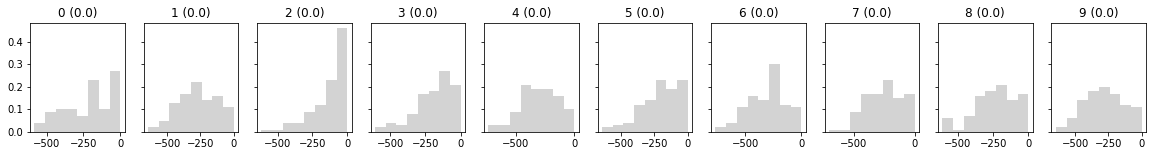

Undecided.


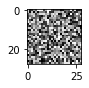

Real:  8


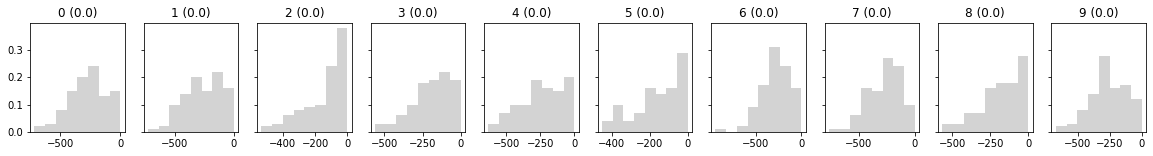

Undecided.


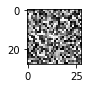

Real:  9


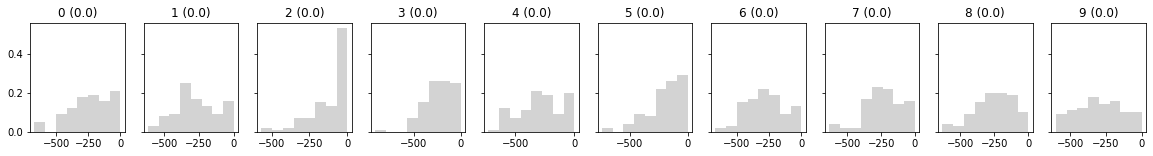

Undecided.


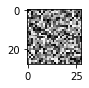

Real:  8


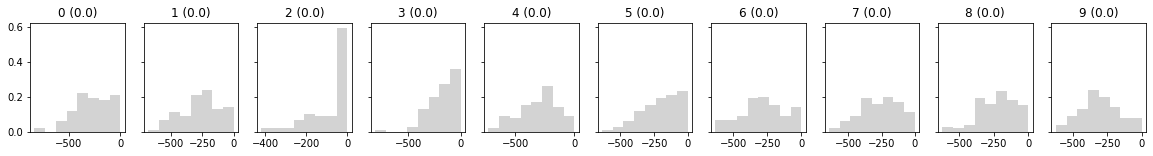

Undecided.


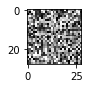

Real:  2


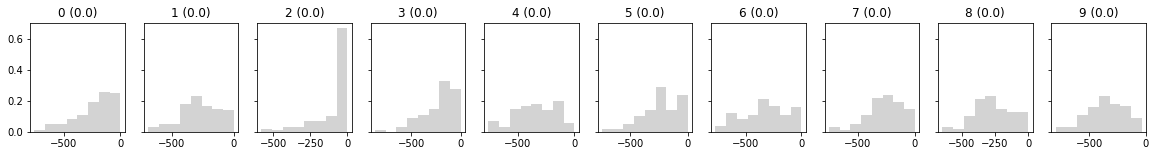

Undecided.


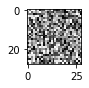

Real:  3


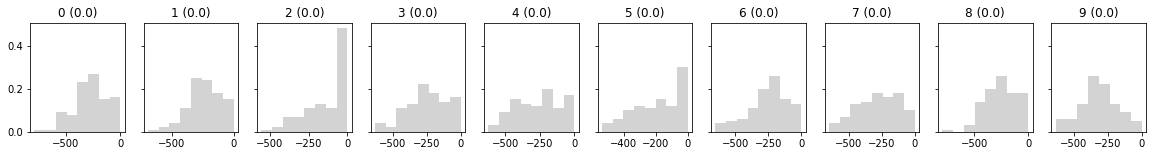

Undecided.


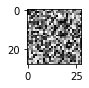

Real:  2


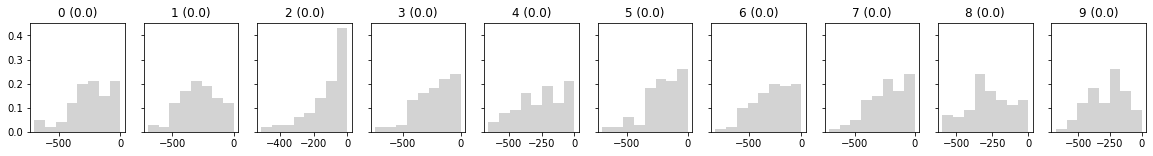

Undecided.


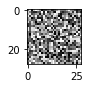

Real:  1


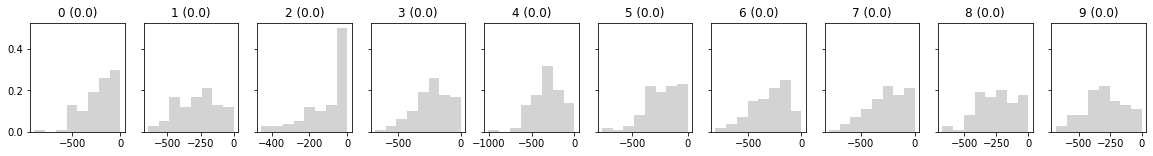

Undecided.


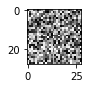

Real:  1


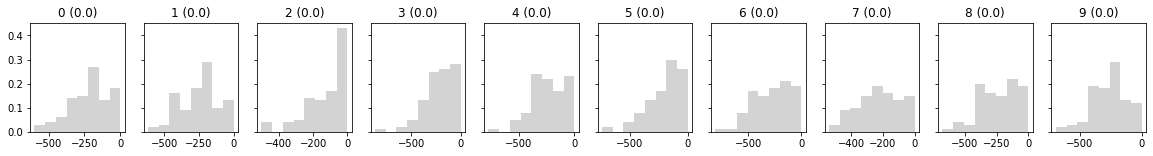

Undecided.


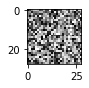

Real:  1


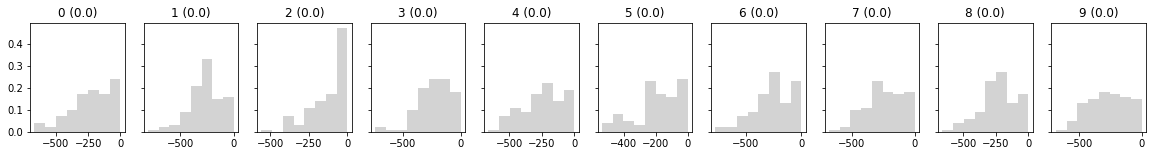

Undecided.


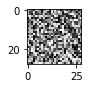

Real:  9


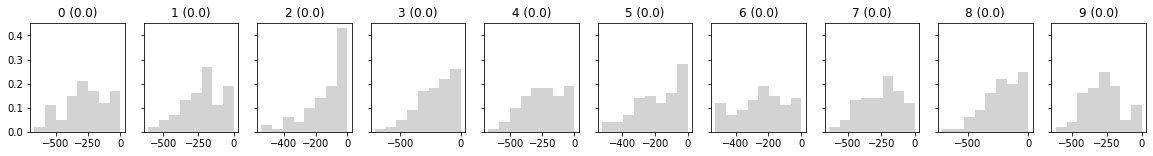

Undecided.


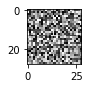

Real:  5


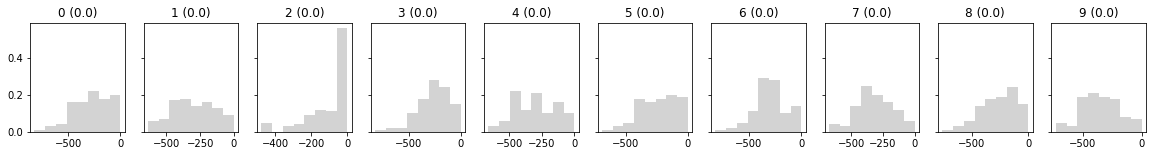

Undecided.


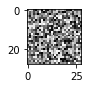

Real:  9


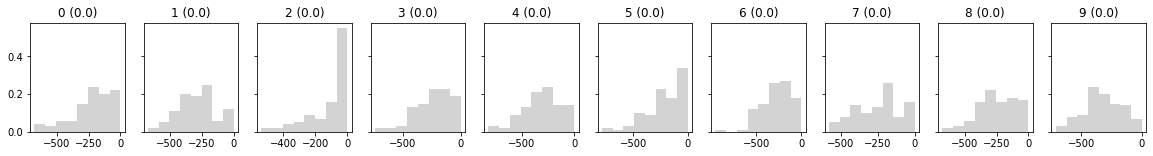

Undecided.


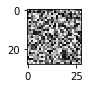

Real:  5


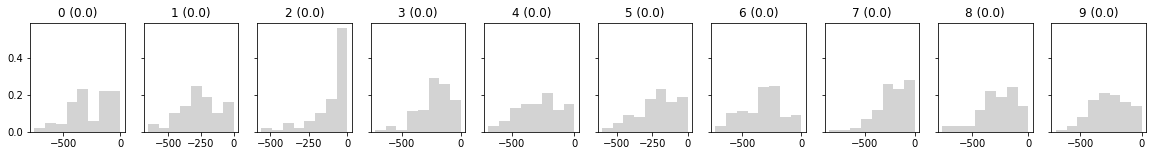

Undecided.


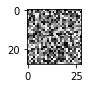

Real:  7


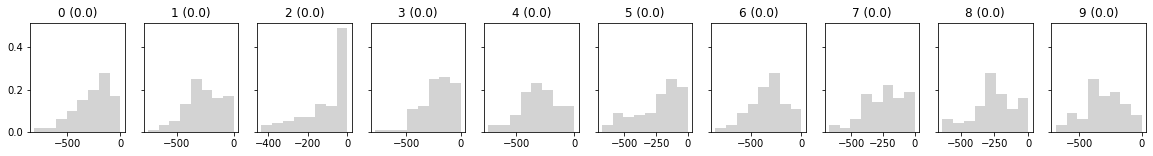

Undecided.


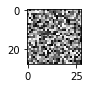

Real:  1


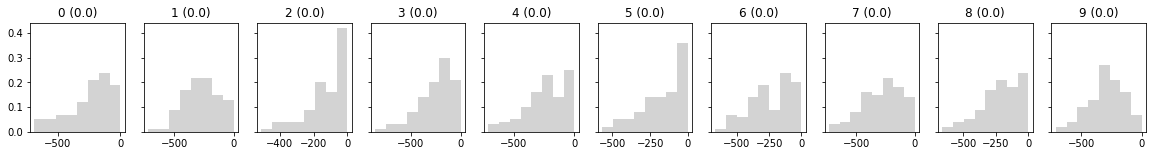

Undecided.


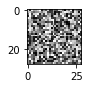

Real:  8


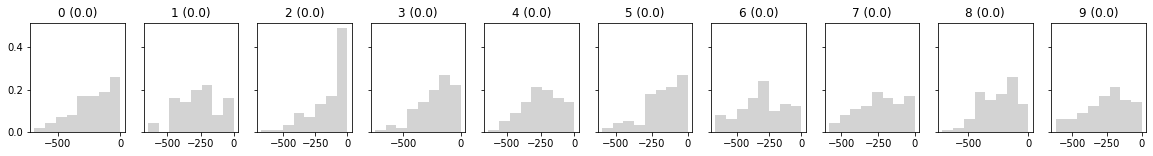

Undecided.


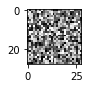

Real:  4


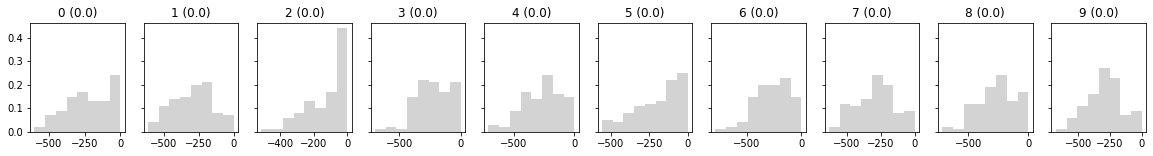

Undecided.


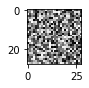

Real:  9


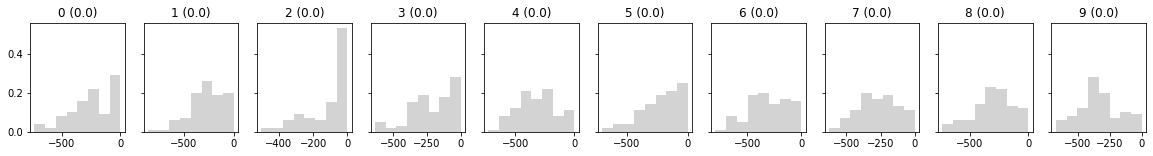

Undecided.


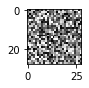

Real:  4


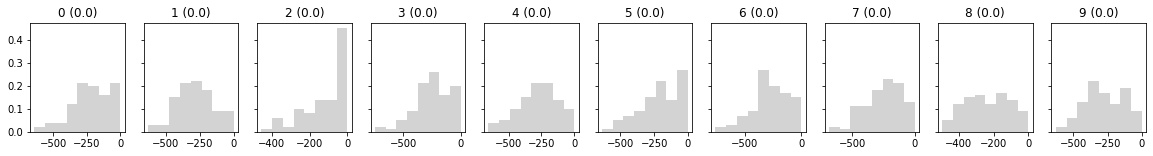

Undecided.


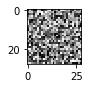

Real:  5


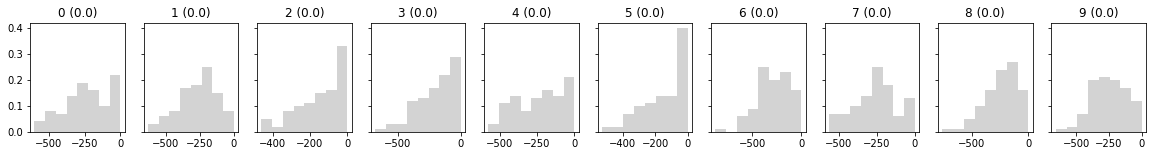

Undecided.


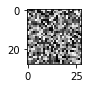

Real:  3


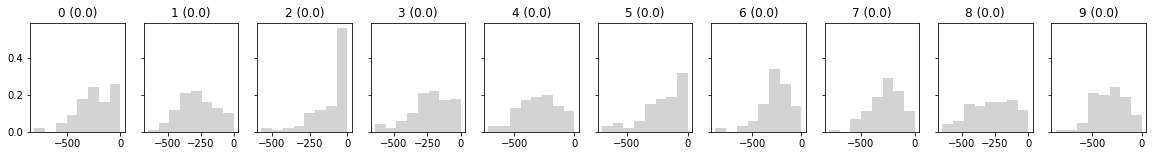

Undecided.


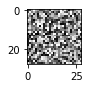

Real:  8


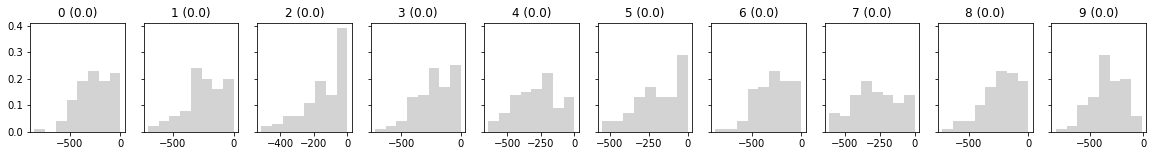

Undecided.


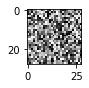

Real:  4


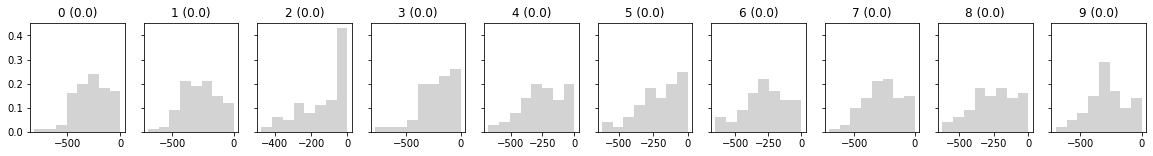

Undecided.


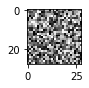

Real:  8


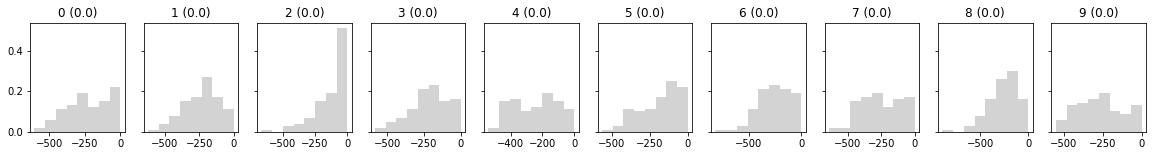

Undecided.


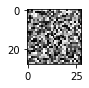

Real:  3


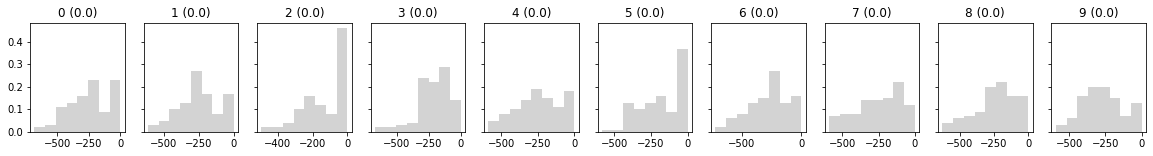

Undecided.


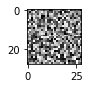

Real:  6


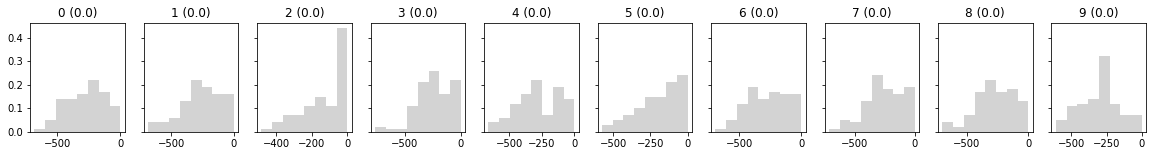

Undecided.


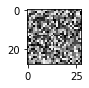

Real:  3


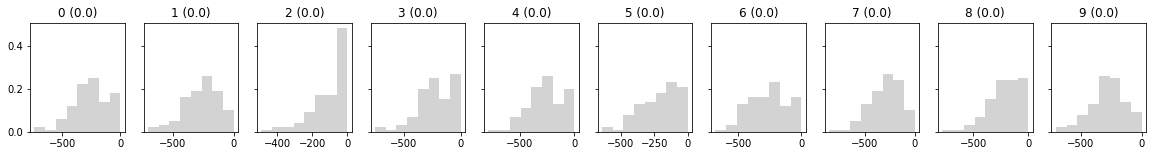

Undecided.


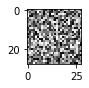

Real:  2


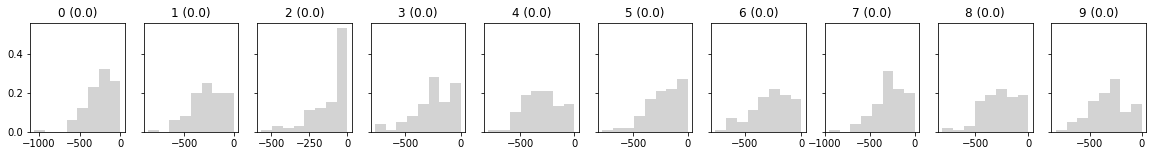

Undecided.


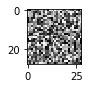

Real:  9


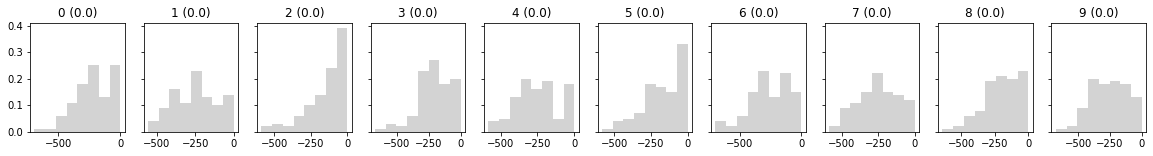

Undecided.


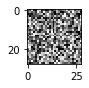

Real:  5


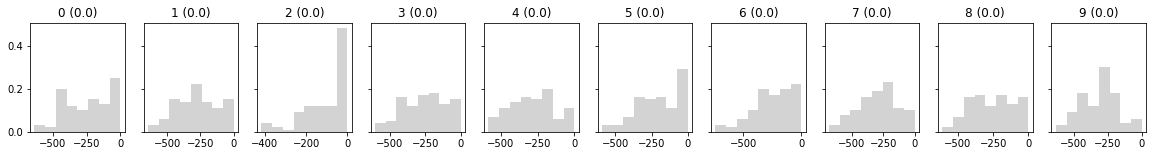

Undecided.


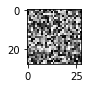

Real:  4


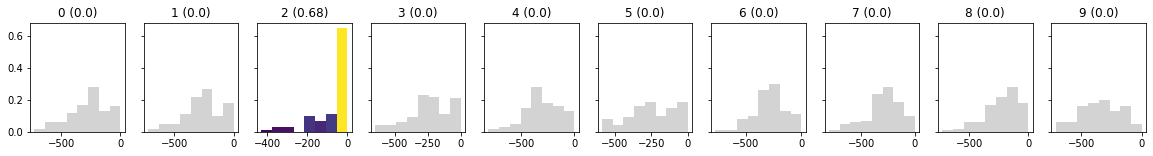

Incorrect :()


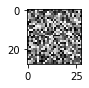

Real:  6


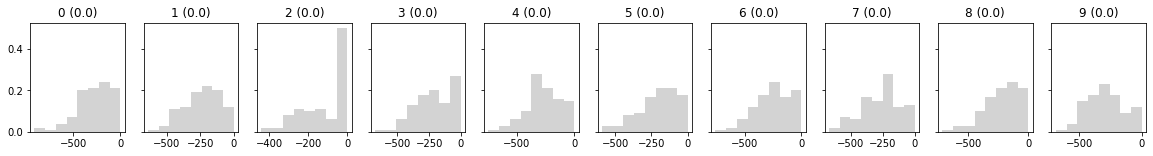

Undecided.


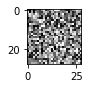

Real:  4


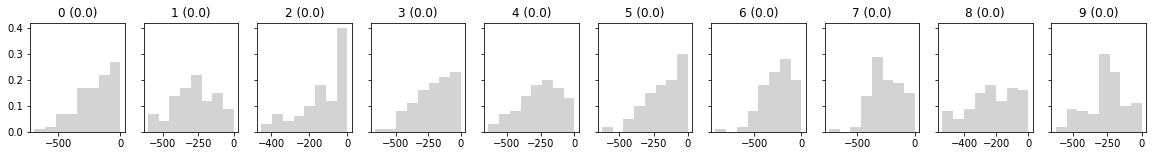

Undecided.


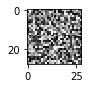

Real:  8


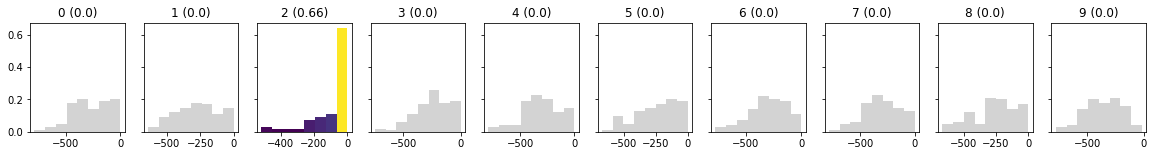

Incorrect :()


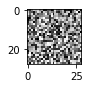

Real:  1


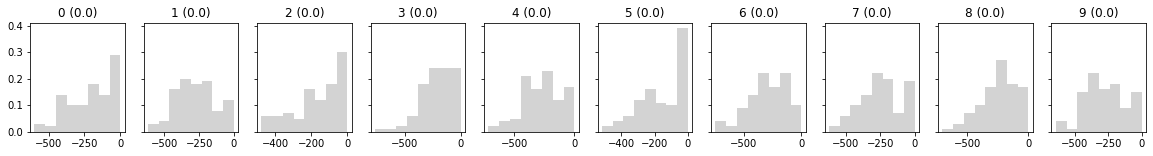

Undecided.


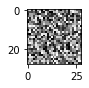

Real:  3


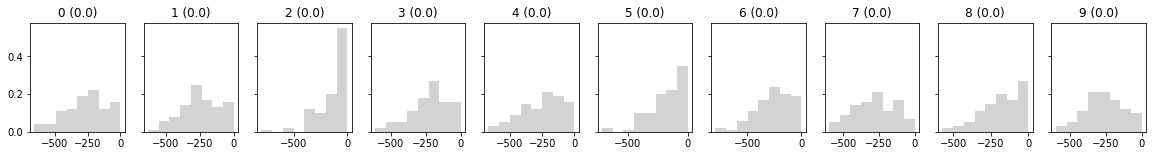

Undecided.


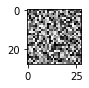

Real:  6


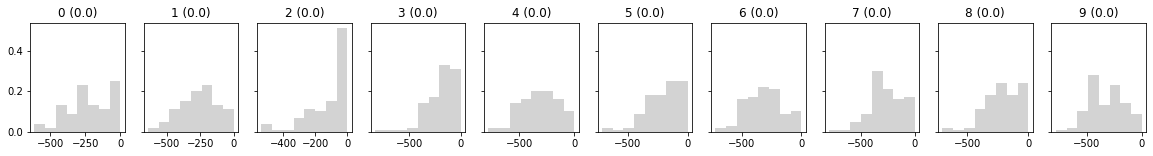

Undecided.


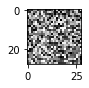

Real:  2


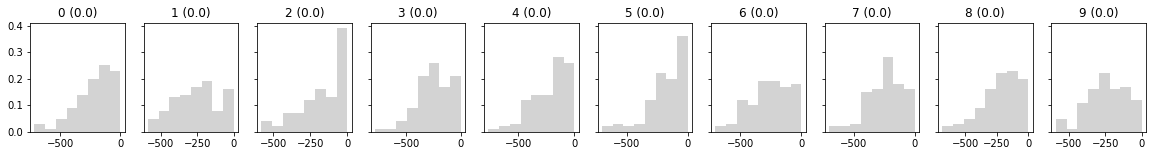

Undecided.


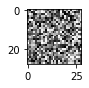

Real:  5


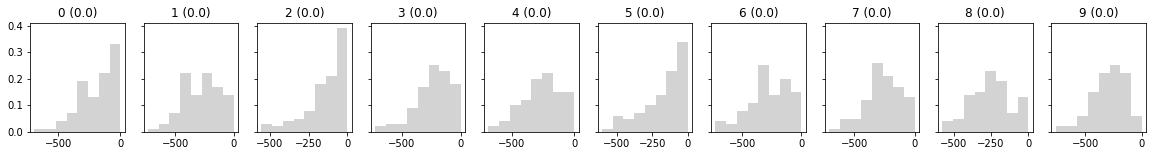

Undecided.


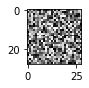

Real:  7


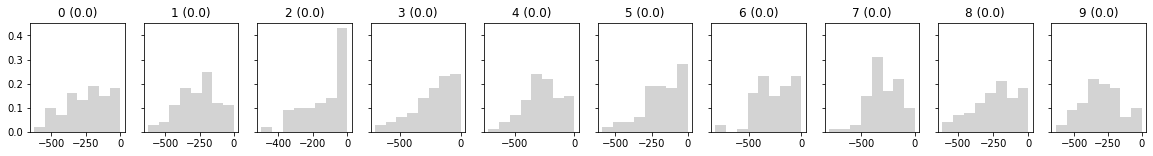

Undecided.


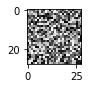

Real:  4


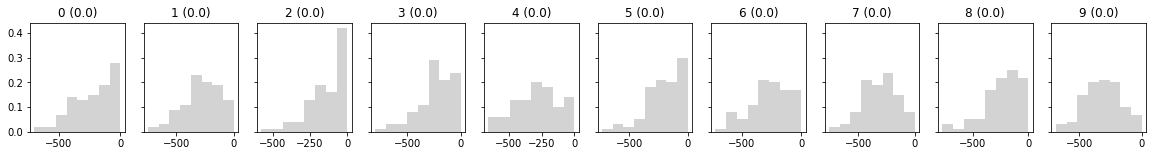

Undecided.


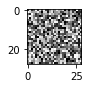

Real:  1


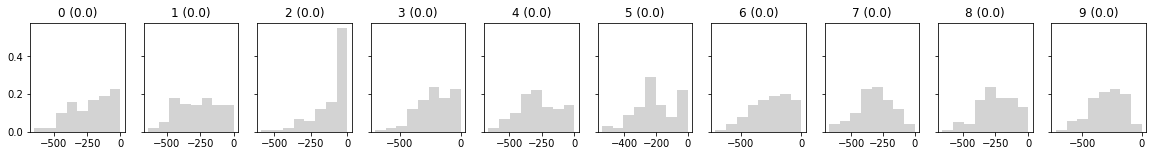

Undecided.


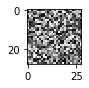

Real:  5


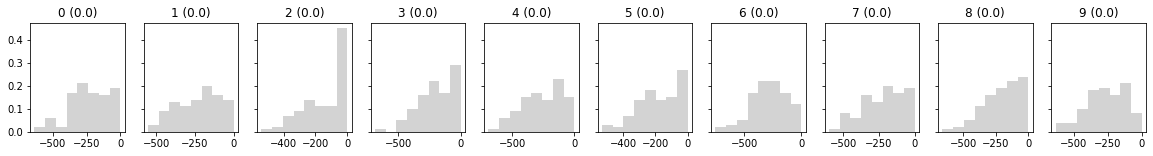

Undecided.


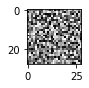

Real:  2


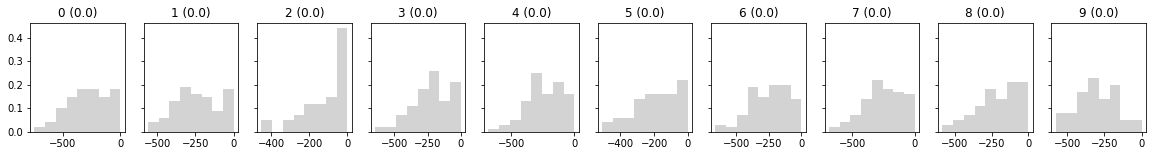

Undecided.


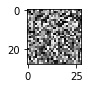

Real:  0


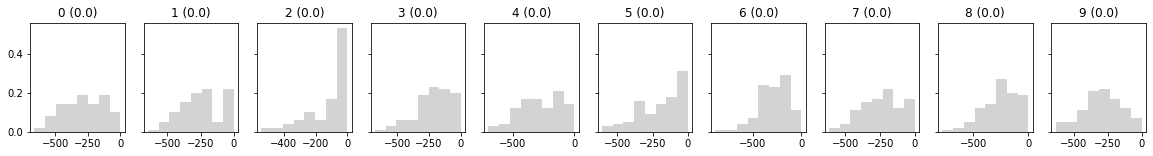

Undecided.


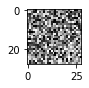

Real:  5


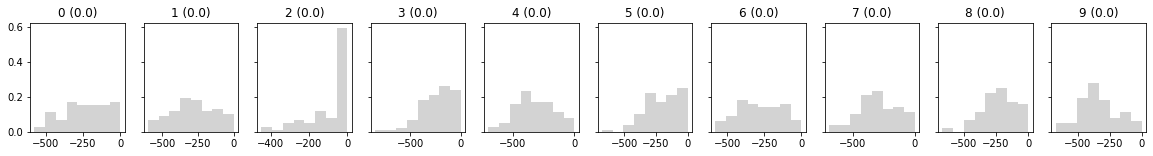

Undecided.


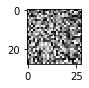

Real:  1


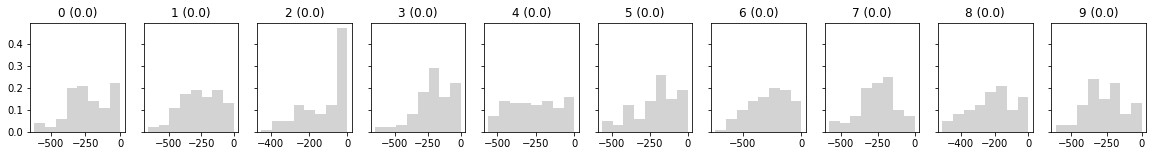

Undecided.


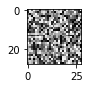

Real:  9


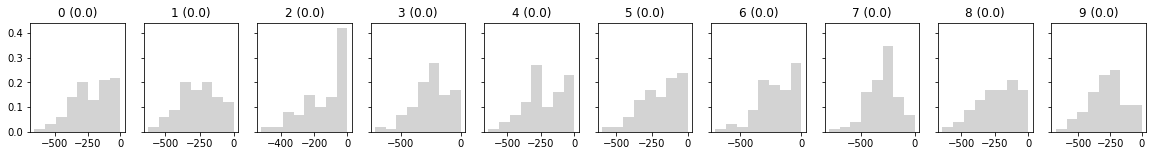

Undecided.


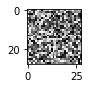

Real:  1


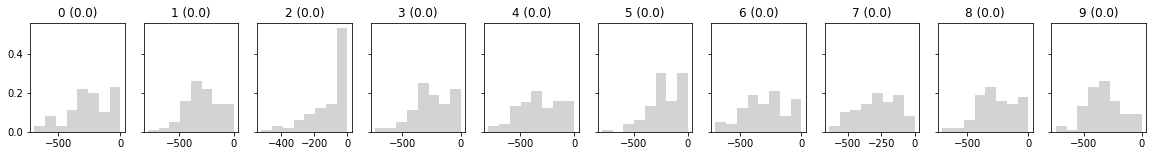

Undecided.


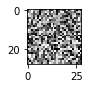

Real:  4


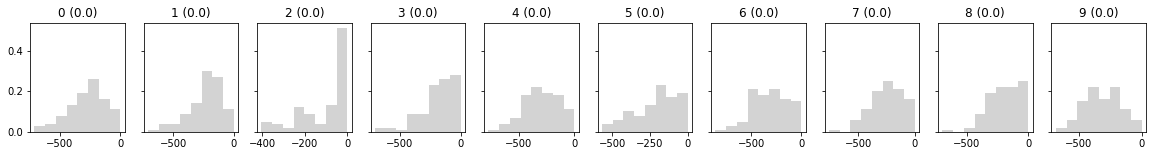

Undecided.


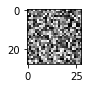

Real:  9


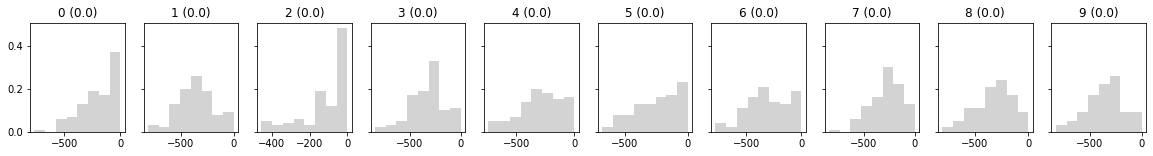

Undecided.


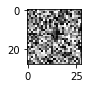

Real:  2


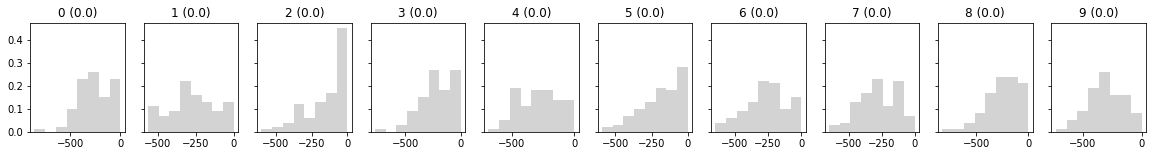

Undecided.


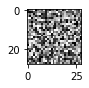

Real:  1


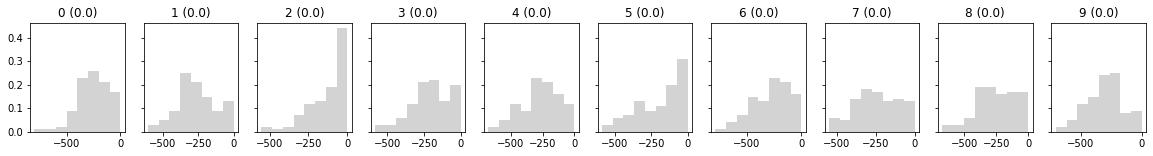

Undecided.


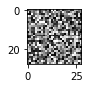

Real:  9


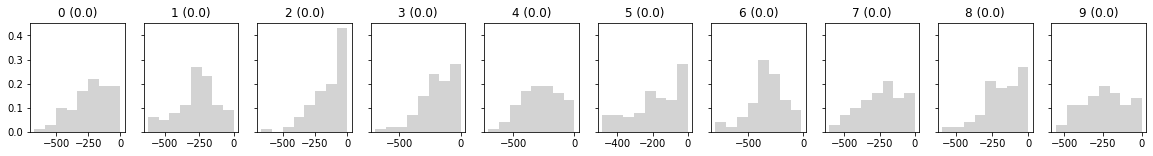

Undecided.


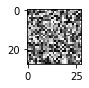

Real:  4


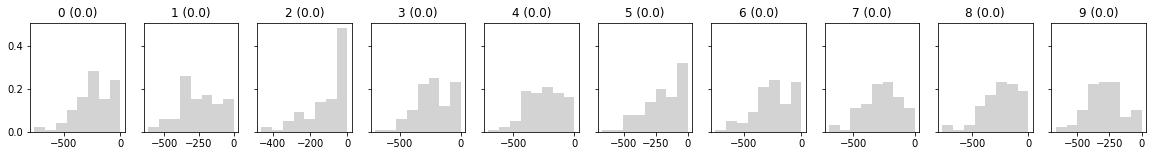

Undecided.


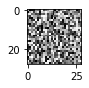

Real:  2


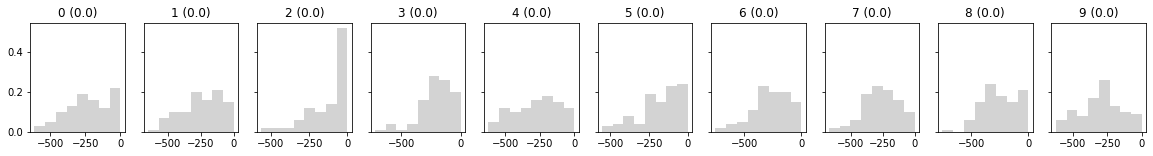

Undecided.


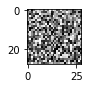

Real:  6


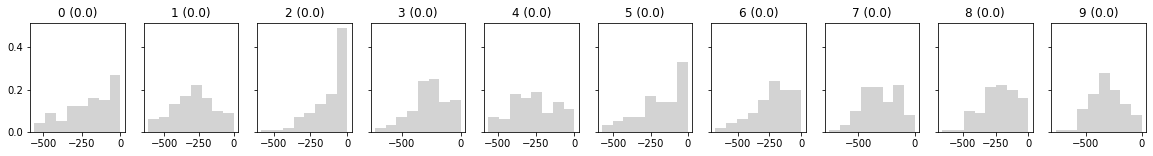

Undecided.


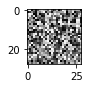

Real:  0


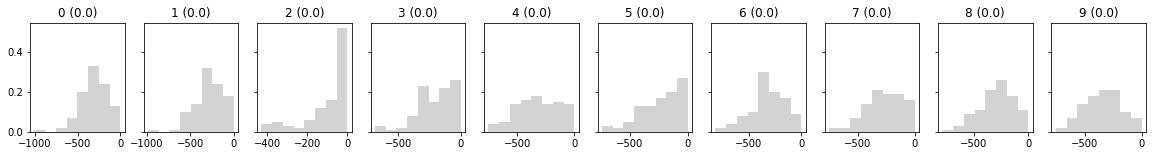

Undecided.


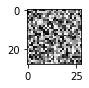

Real:  5


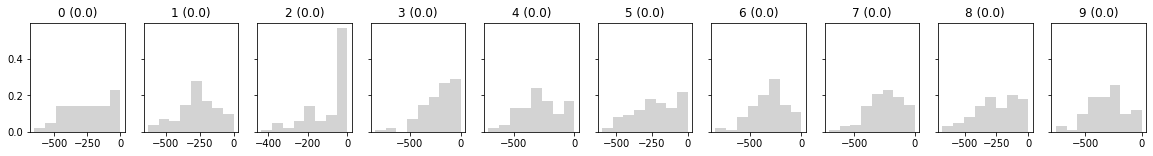

Undecided.


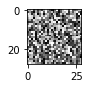

Real:  9


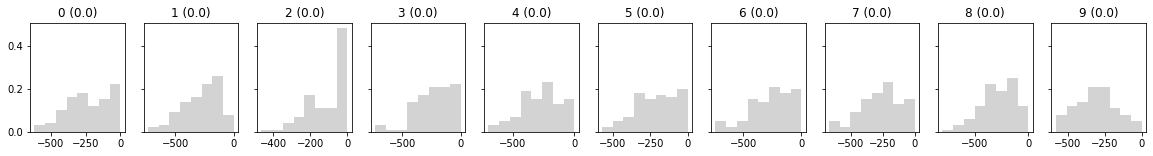

Undecided.


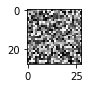

Real:  6


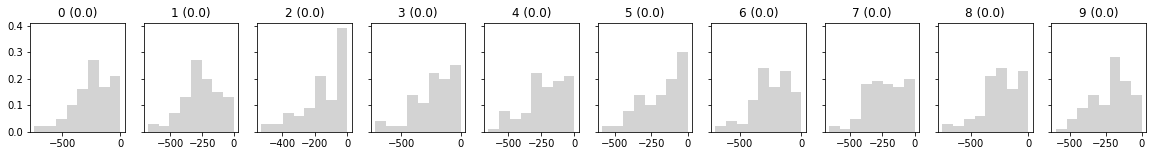

Undecided.


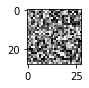

Real:  1


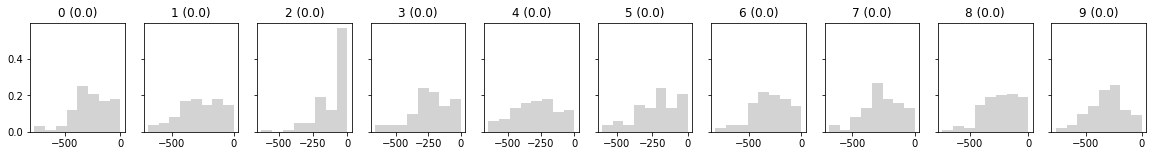

Undecided.


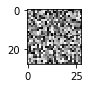

Real:  8


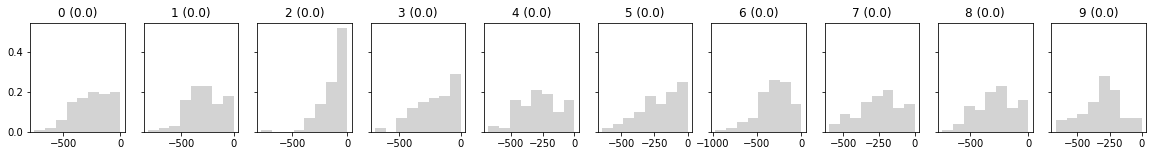

Undecided.


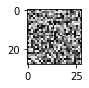

Real:  6


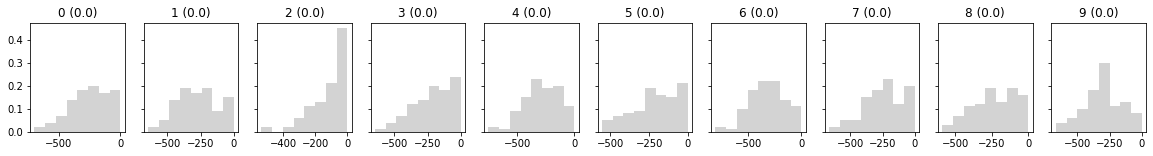

Undecided.


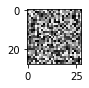

Real:  9


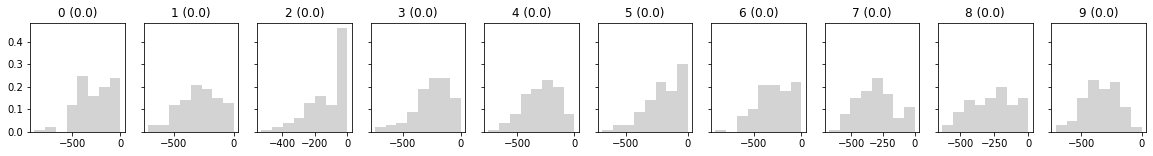

Undecided.


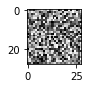

Real:  4


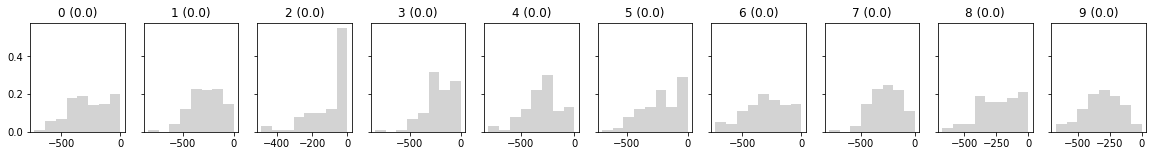

Undecided.


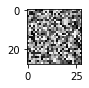

Real:  6


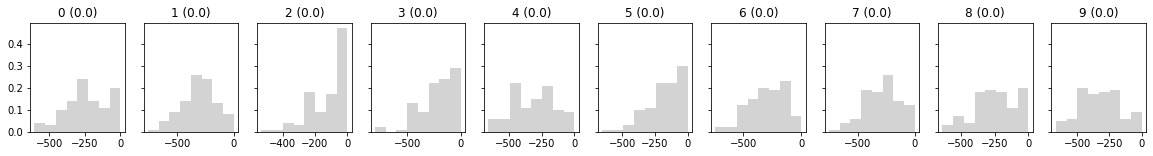

Undecided.


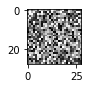

Real:  9


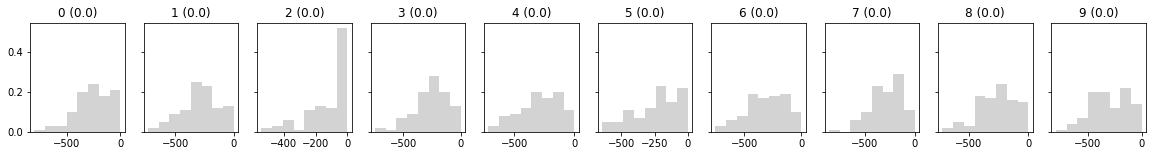

Undecided.


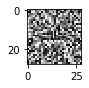

Real:  1


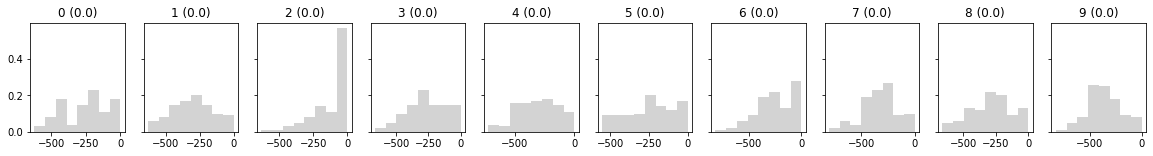

Undecided.


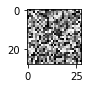

Real:  0


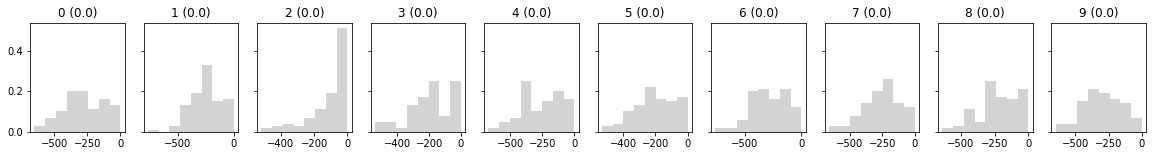

Undecided.


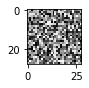

Real:  6


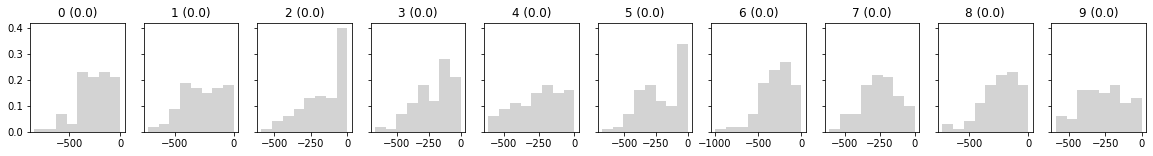

Undecided.


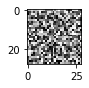

Real:  0


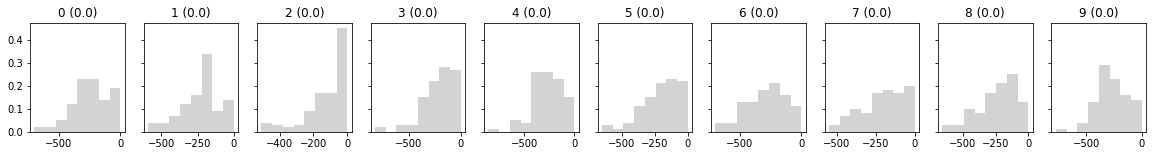

Undecided.


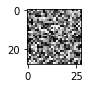

Real:  5


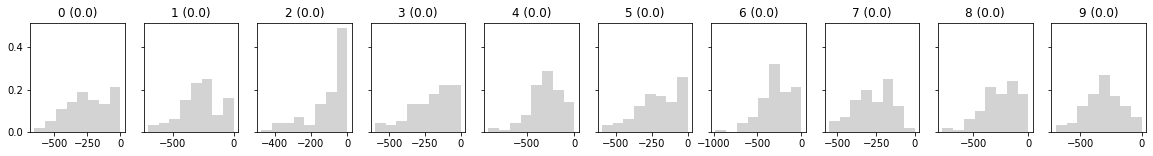

Undecided.


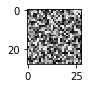

Summary
Total images:  100
Predicted for:  3
Accuracy when predicted:  0.0


(100, 0, 3)

In [51]:
test_batch(images_random, labels_random)

In [0]:
class data_loader(Dataset):
	def __init__(self, root):
		Images, Y = [], []
		folders = os.listdir(root)
		folders = folders[1:]

		for folder in folders:
            
			folder_path = os.path.join(root, folder)
			print(folder_path)
            
            
            
			for ims in os.listdir(folder_path):

				img_path = os.path.join(folder_path, ims)
				Images.append(np.array(imageo.imread(img_path)))
				Y.append(ord(folder) - 65)  # Folders are A-J so labels will be 0-9
				
		data = [(x, y) for x, y in zip(Images, Y)]
		self.data = data

	def __len__(self):
		return len(self.data)

	def __getitem__(self, index):
		img = self.data[index][0]

		# 8 bit images. Scale between 0, 1
		img = img.reshape(1, 28, 28) / 255

		# Input for Conv2D should be Channels x Height x Width
		img_tensor = transforms.ToTensor()(img).view(1, 28, 28).float()
		label = self.data[index][1]
		return (img_tensor, label)